In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics.cluster import contingency_matrix
from scipy.stats import chi2_contingency

from utils import *
from exp_utils import *
from tests import *
from cd_models import *

####### Fixing Seed #######
random_seed=2
np.random.seed(random_seed)
###########################

%config InlineBackend.figure_format = 'retina'

In [2]:
values1 = [0]
print(values1, len(values1))

values2 = [0]
print(values2, len(values2))

[0] 1
[0] 1


In [3]:
B=5
n_p=50000
alpha=.05
perc=list(range(20,100,20)) #percentiles for binning
n = 5000
test=.5

# Label & Conc. 1 

In [4]:
d=3
task='class'

## Label shift

In [5]:
pvals=[]

for k in tqdm(range(n_p)):
    for gamma in [0]:
        for delta in values1:

            ### Generating data ###
            Xs, ys, Xt, yt = GenData2(gamma, delta, d=d, n=n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)            
        
            ### Ztest ###
            pval_z=ztest(ys, yt)
            
            ### Chi2 ###
            contingency = contingency_matrix(np.hstack((yt, ys)), np.hstack((np.ones(yt.shape[0]),np.zeros(ys.shape[0]))))
            pval_chi2=chi2_contingency(contingency)[1]
            
            ### Classifier ###
            pval_class = classifier_test(ys_train, ys_test, yt_train, yt_test)
            
            ### TV ###
            pval_tv = permut_test(tv,ys,yt,B)
            
            ### Ours ###
            lab=PermutDiscrete(get_dummies(ys), get_dummies(yt), B=B, verbose=False)
            pval_kl = lab['pval']
 
            ### Output ###
            pvals.append([delta, pval_z, pval_chi2, pval_class, pval_tv, pval_kl])

100%|█████████████████████████████████████| 50000/50000 [37:53<00:00, 22.00it/s]




  ********** Z **********


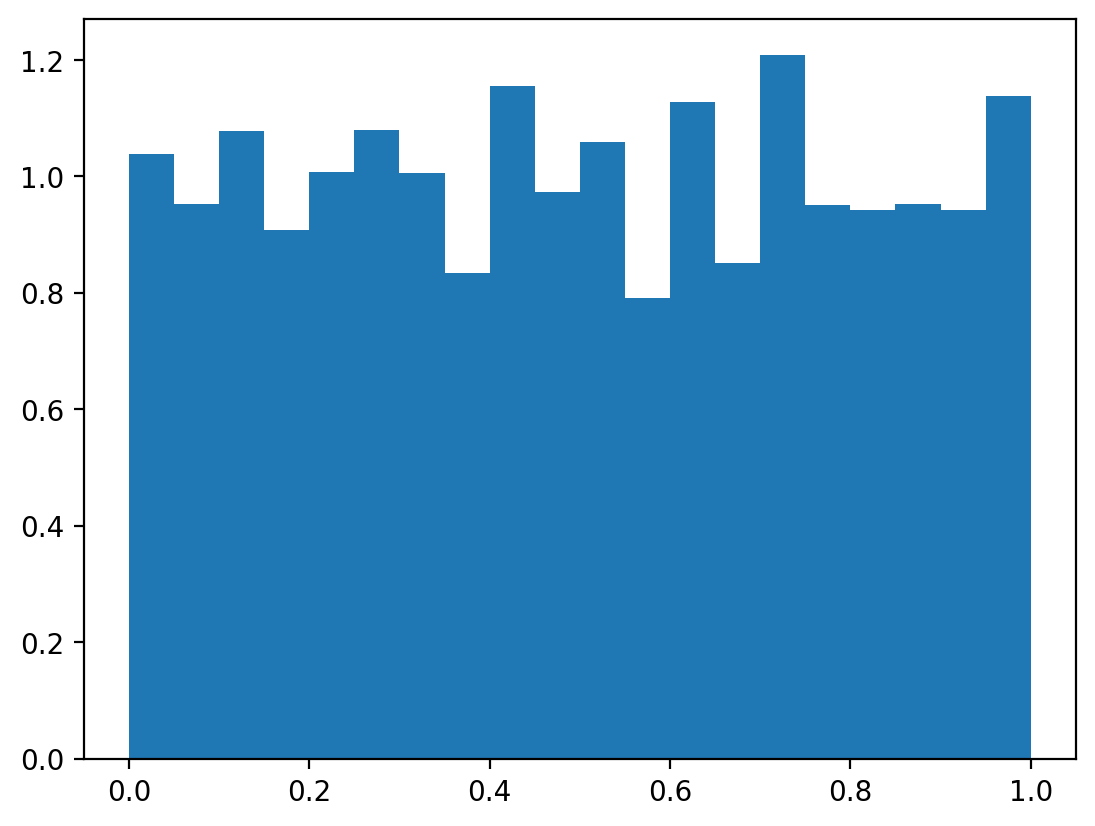

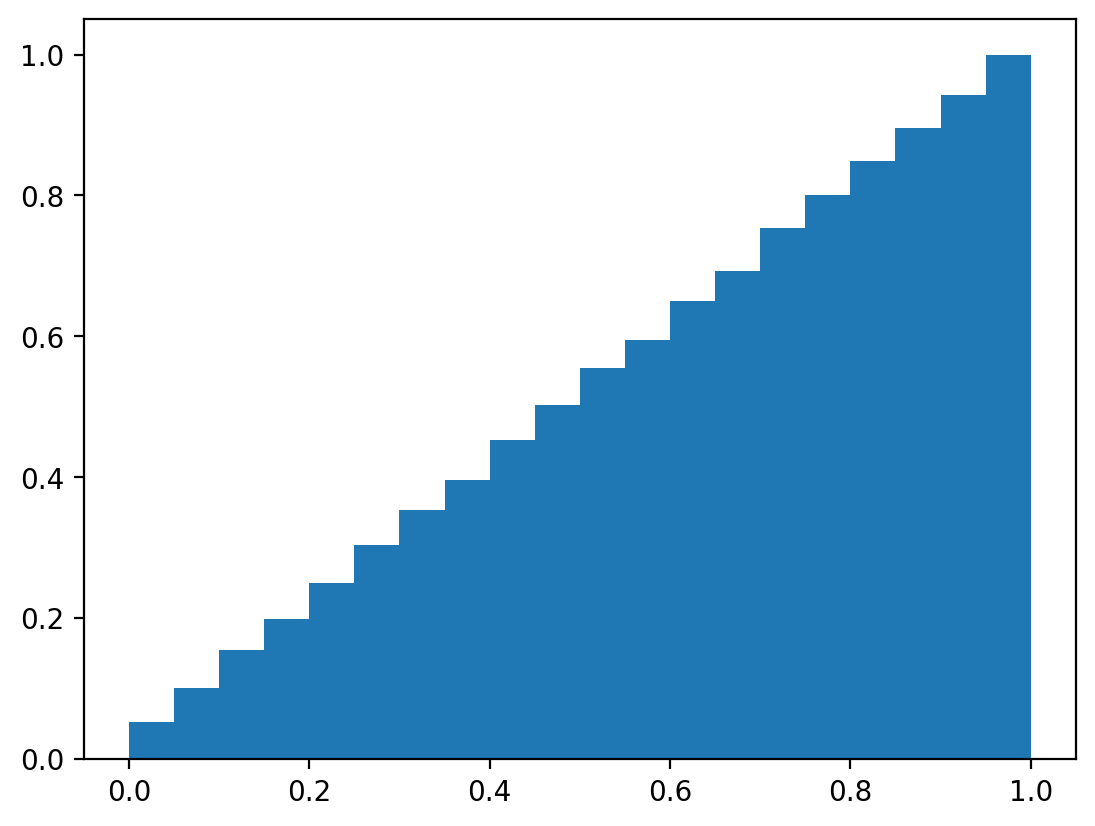



  ********** $\chi^2$ **********


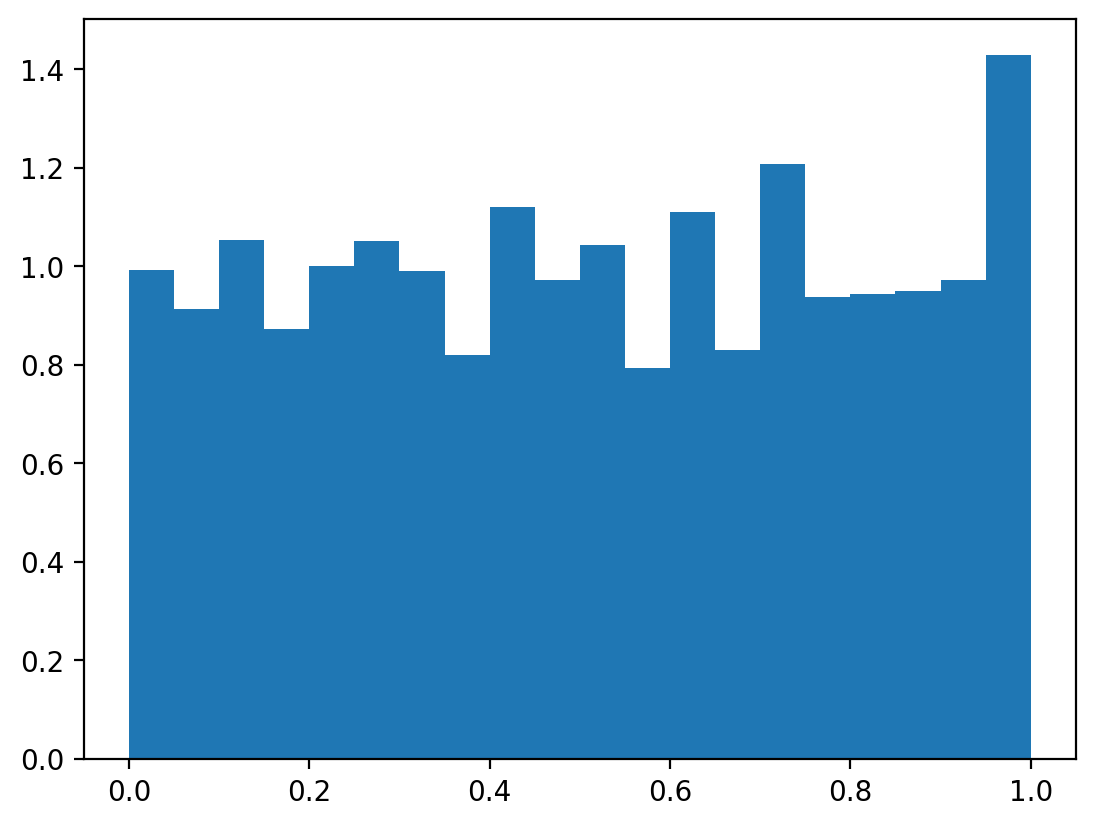

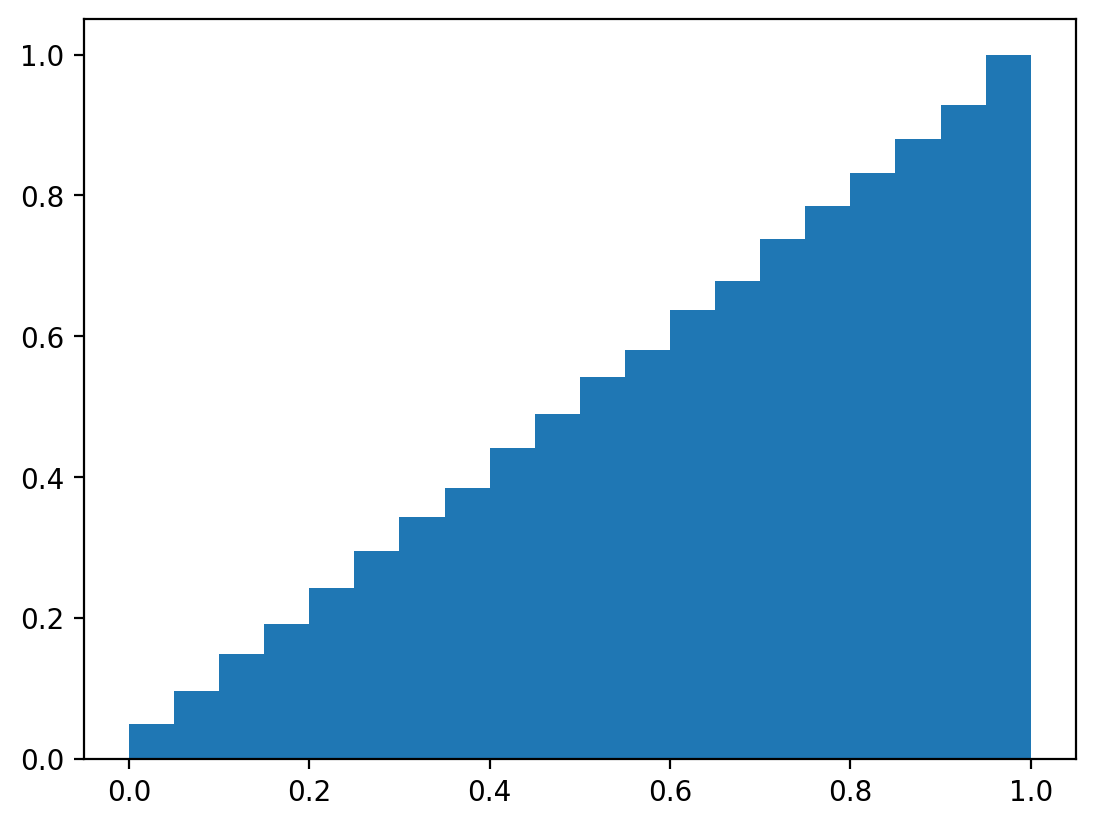



  ********** Class. **********


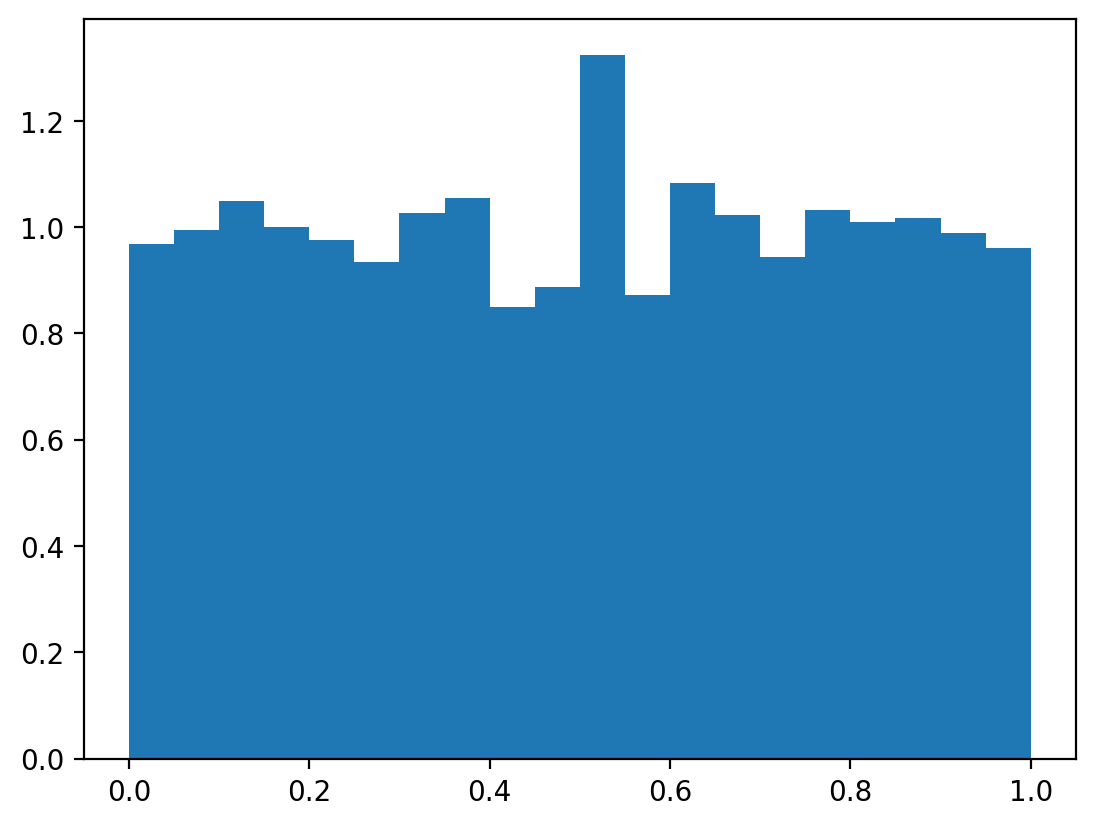

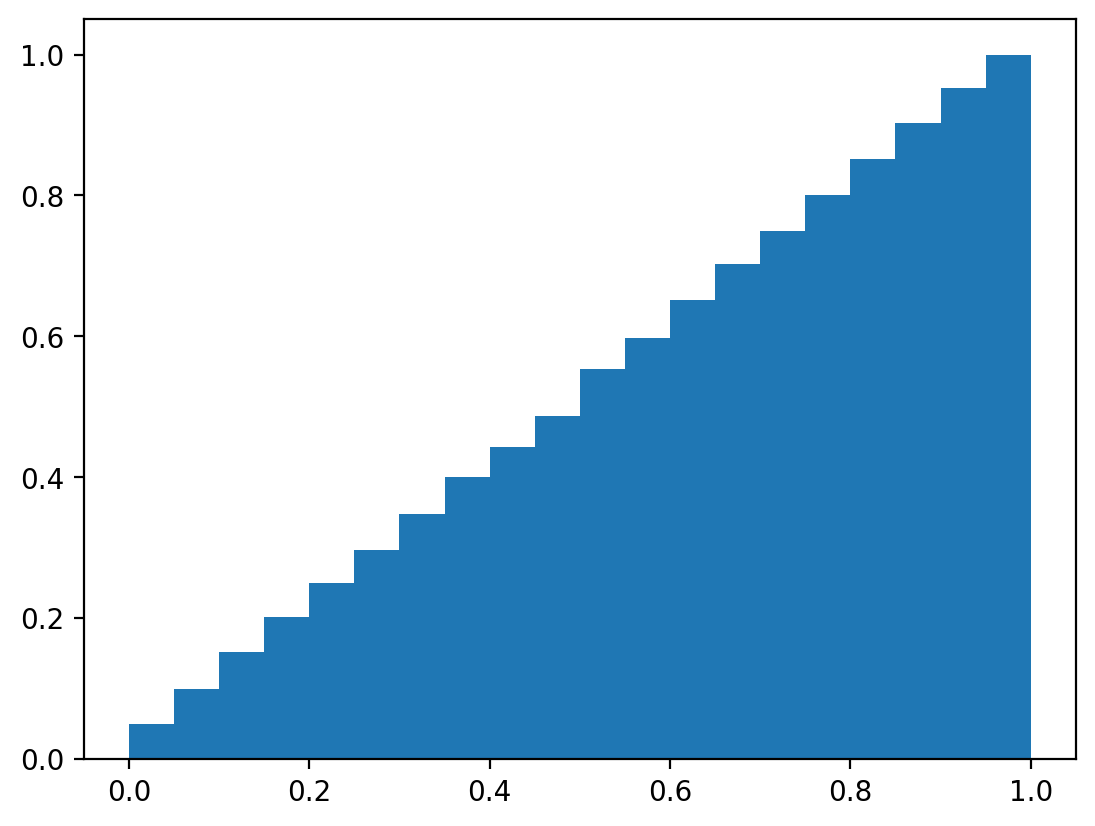



  ********** TV **********


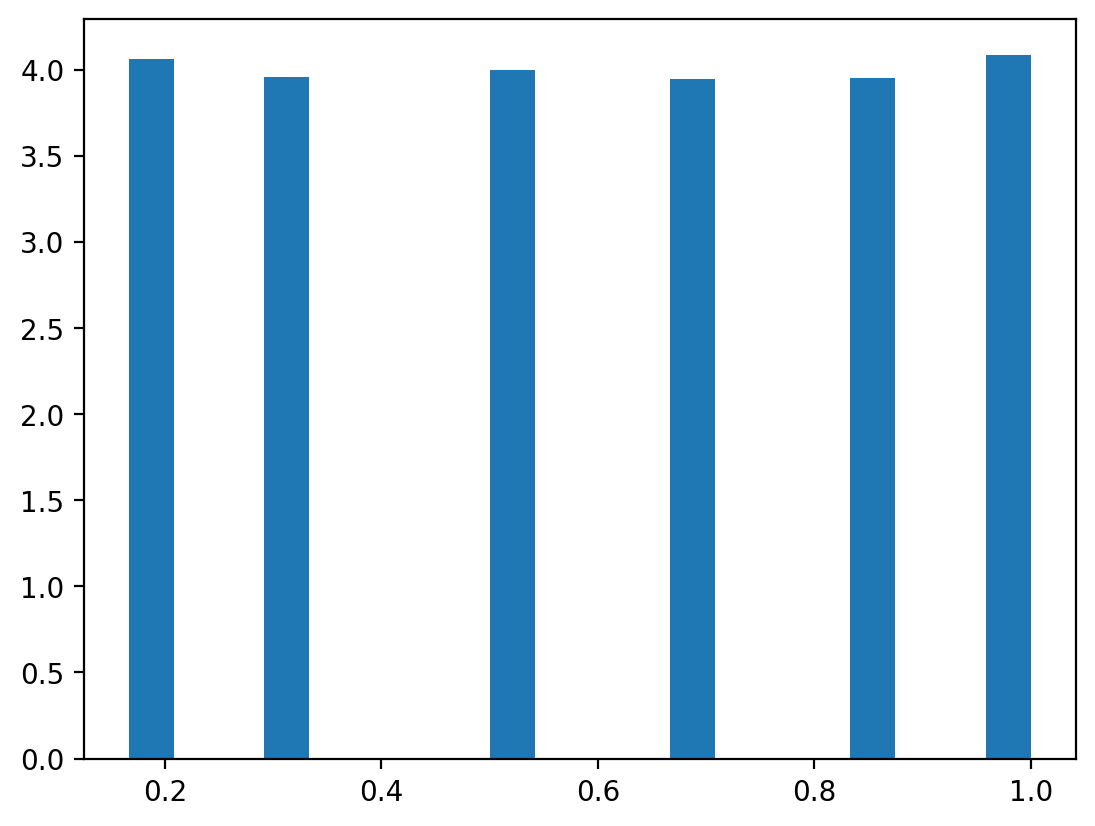

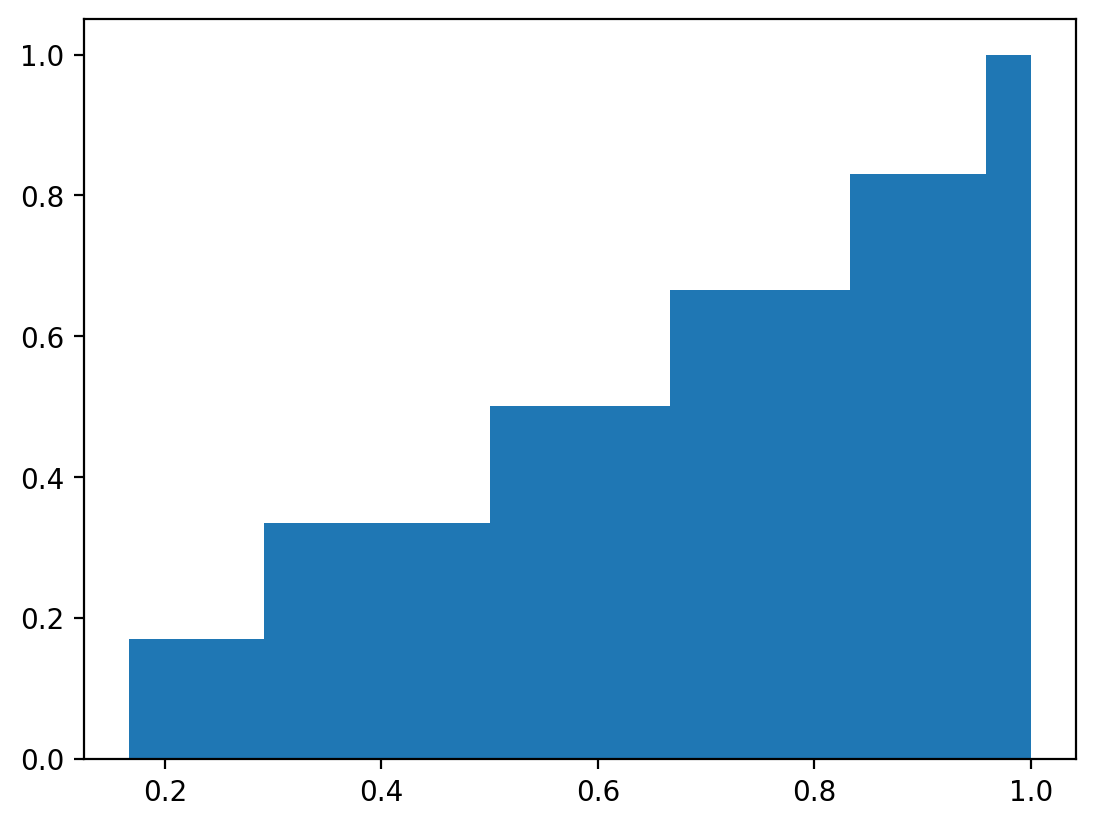



  ********** KL **********


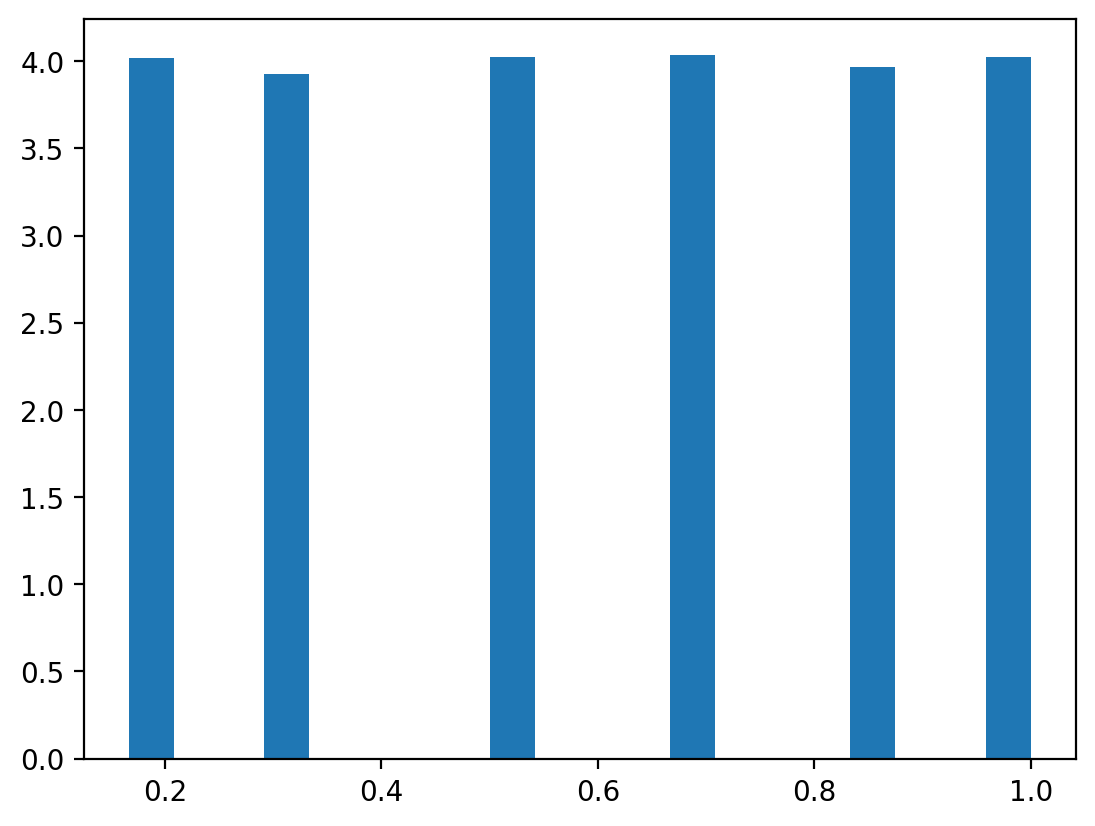

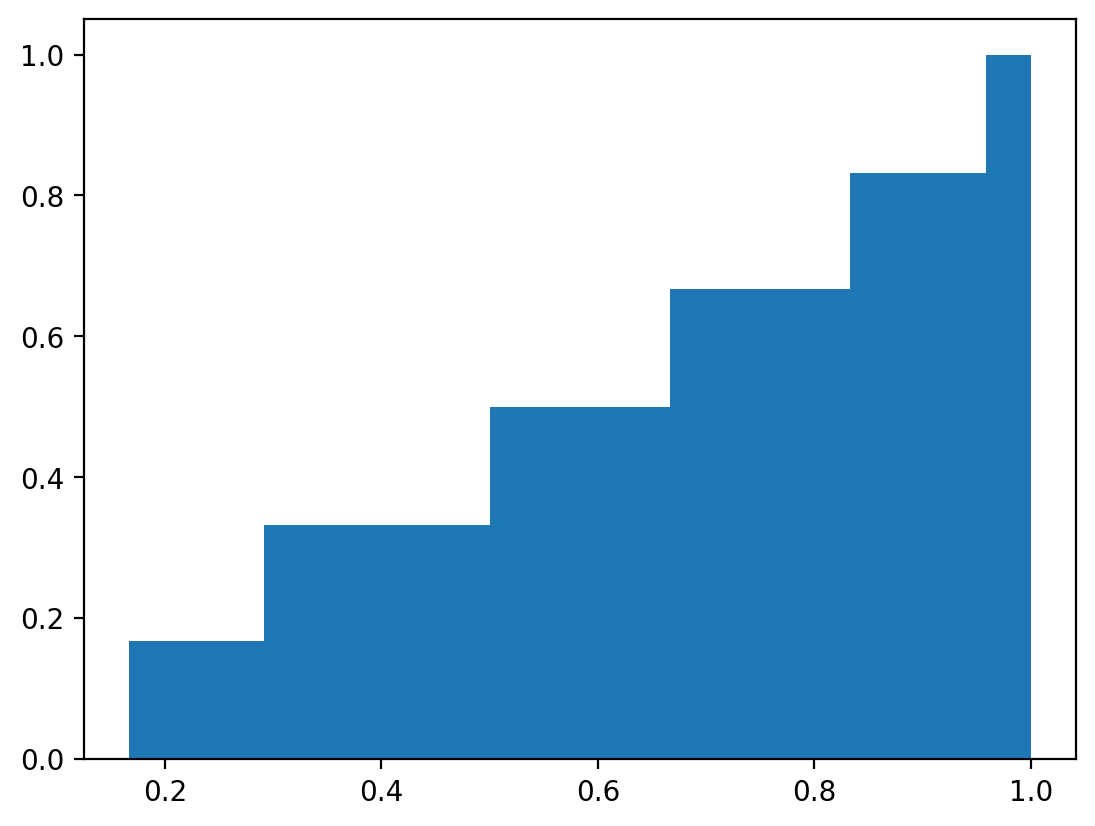

In [6]:
pvals=np.array(pvals)

names=['Z', '$\chi^2$', 'Class.', 'TV', 'KL']

for i in range(len(names)):
    print("\n\n  **********",names[i],"**********")
    plt.hist(pvals[:,i+1], cumulative=False, density=True, bins=20)
    plt.show()
    plt.hist(pvals[:,i+1], cumulative=True, density=True, bins=20)
    plt.show()

## Conc shift 1

In [7]:
pvals=[]

for k in tqdm(range(n_p)):
    for gamma in values1:
        for delta in [0]:

            ### Generating data ###
            Xs, ys, Xt, yt = GenData2(gamma, delta, d=d, n=n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)            

            ### class & proba
            pval_class, pval_proba = ci_test1(Xs_train, Xs_test, ys_train, ys_test, Xt_train, Xt_test, yt_train, yt_test, B, boost=True, cv=None)
            
            ### TV
            Xbins = np.percentile(np.vstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)
            
            df = pd.DataFrame(Xs_bin, dtype='str')
            df['concat'] = df[0] +  df[1] + df[2]
            Xs_bin=np.array(df['concat'], dtype='int')
            
            df = pd.DataFrame(Xt_bin, dtype='str')
            df['concat'] = df[0] +  df[1] + df[2] 
            Xt_bin=np.array(df['concat'], dtype='int')
            
            y = np.hstack((ys,yt))
            X_bin = np.hstack((Xs_bin,Xt_bin))
            
            concshift=tv_conc(ys,Xs_bin,yt,Xt_bin)
            concperm = []
            
            Y=np.unique(np.array(y))
            ind={}
            for j in Y:
                ind[j] = (np.array(y)==j).squeeze()

            for b in range(B):
                X_perm = np.zeros(X_bin.shape)
                shuffle={}
                for j in Y:
                    shuffle[j] = np.random.choice(range(np.sum(ind[j])), size=(np.sum(ind[j]),), replace=False)
                    X_perm[ind[j]] = X_bin[ind[j]][shuffle[j]]

                concperm.append(tv_conc(ys,X_perm[:Xs_bin.shape[0]],yt,X_perm[Xs_bin.shape[0]:]))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            concperm=np.array(concperm)
            concperm=concperm+np.random.normal(0,s,concperm.shape[0])
            concshift=concshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(concperm) >= concshift))/(B+1)
            
            
            ### Ours ###
            totshift_model = KL(boost=False, cv=None)
            totshift_model.fit(Zs_train, Zt_train)

            conc1=LocalPermut(Xs_test, ys_test, Xt_test, yt_test, 
                              totshift_model, labshift_model=None, task=task, B=B, verbose=False)
        
            pval_kl = conc1['pval']
 

            ### Output ###
            pvals.append([gamma, pval_class, pval_proba, pval_tv, pval_kl])

100%|███████████████████████████████████| 50000/50000 [4:11:11<00:00,  3.32it/s]




  ********** Class. **********


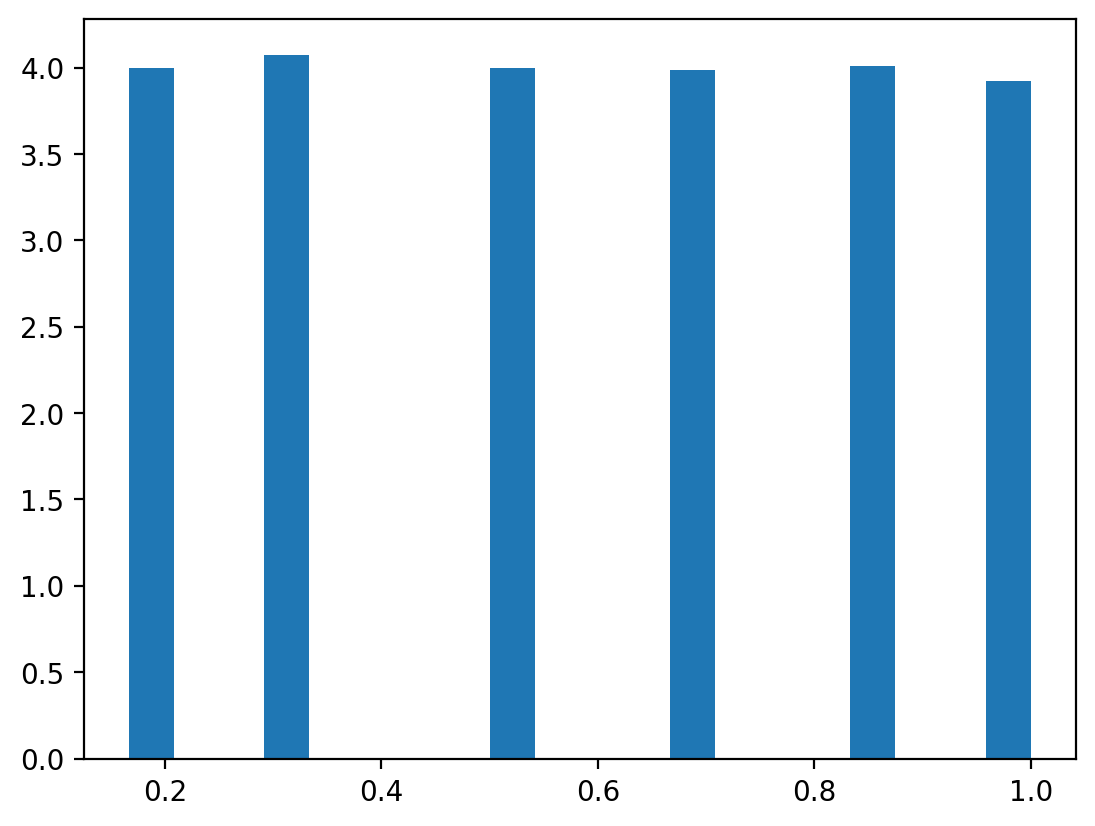

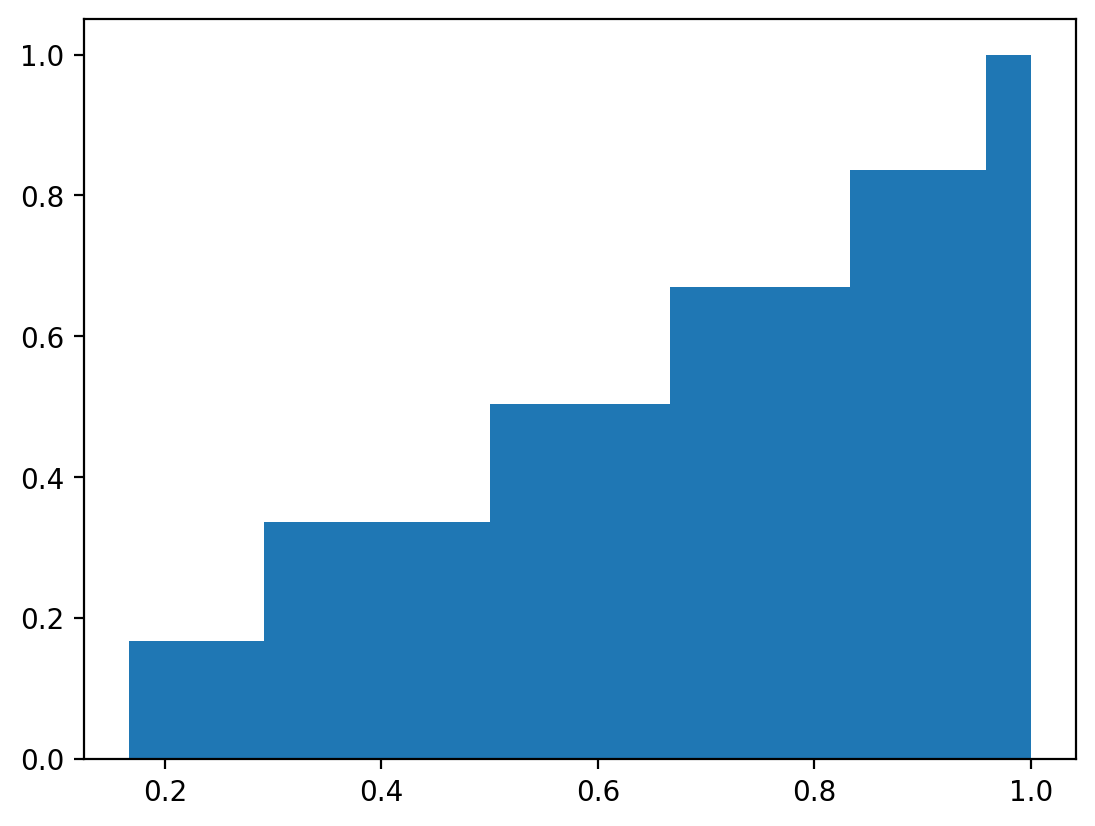



  ********** Proba. **********


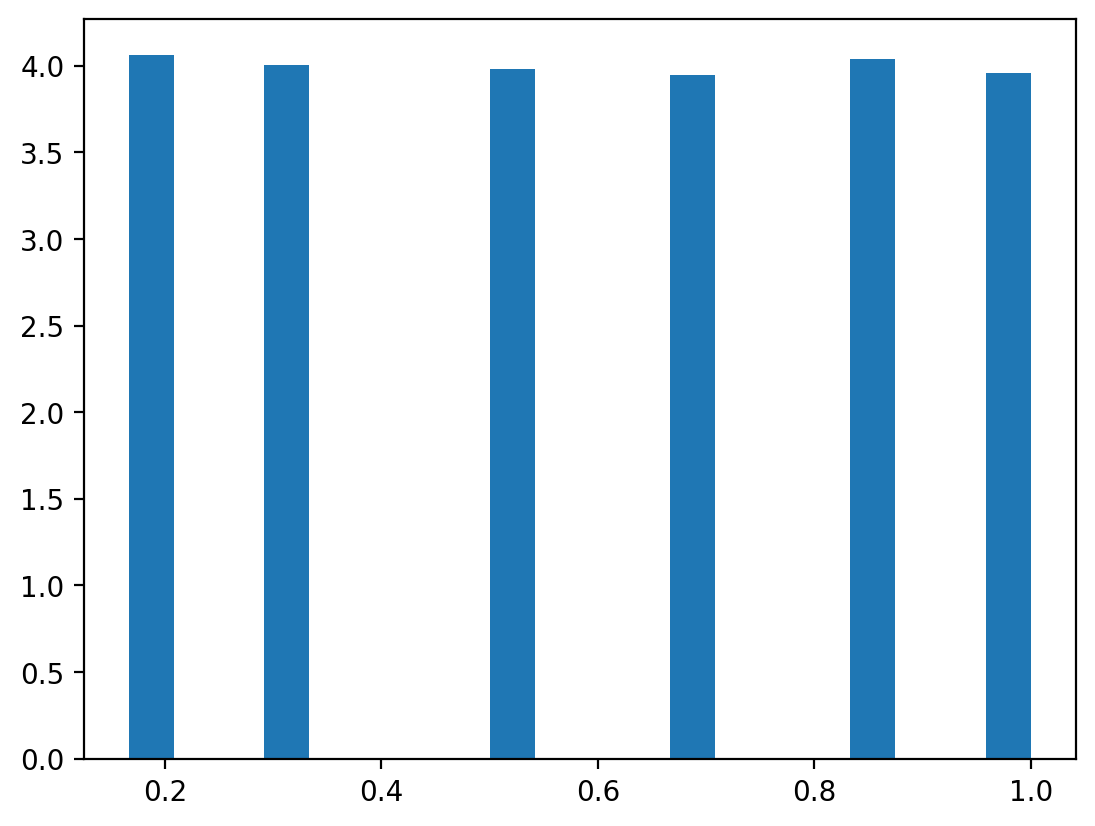

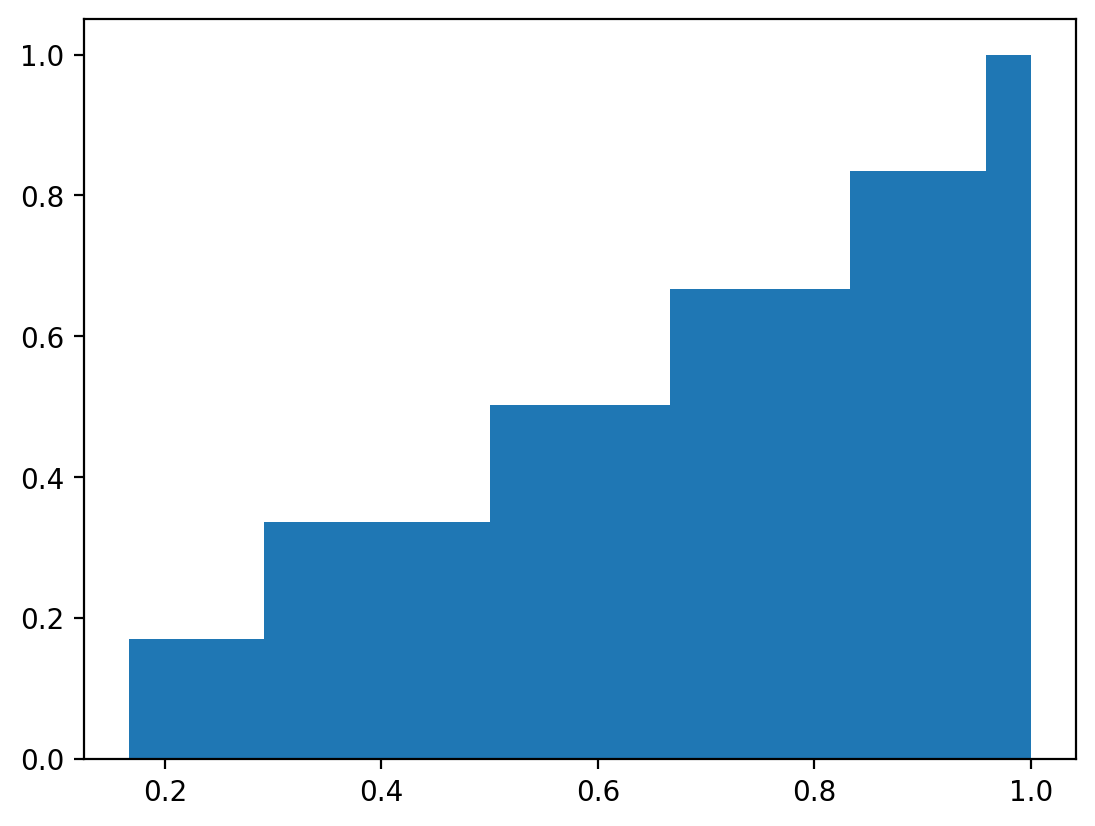



  ********** TV **********


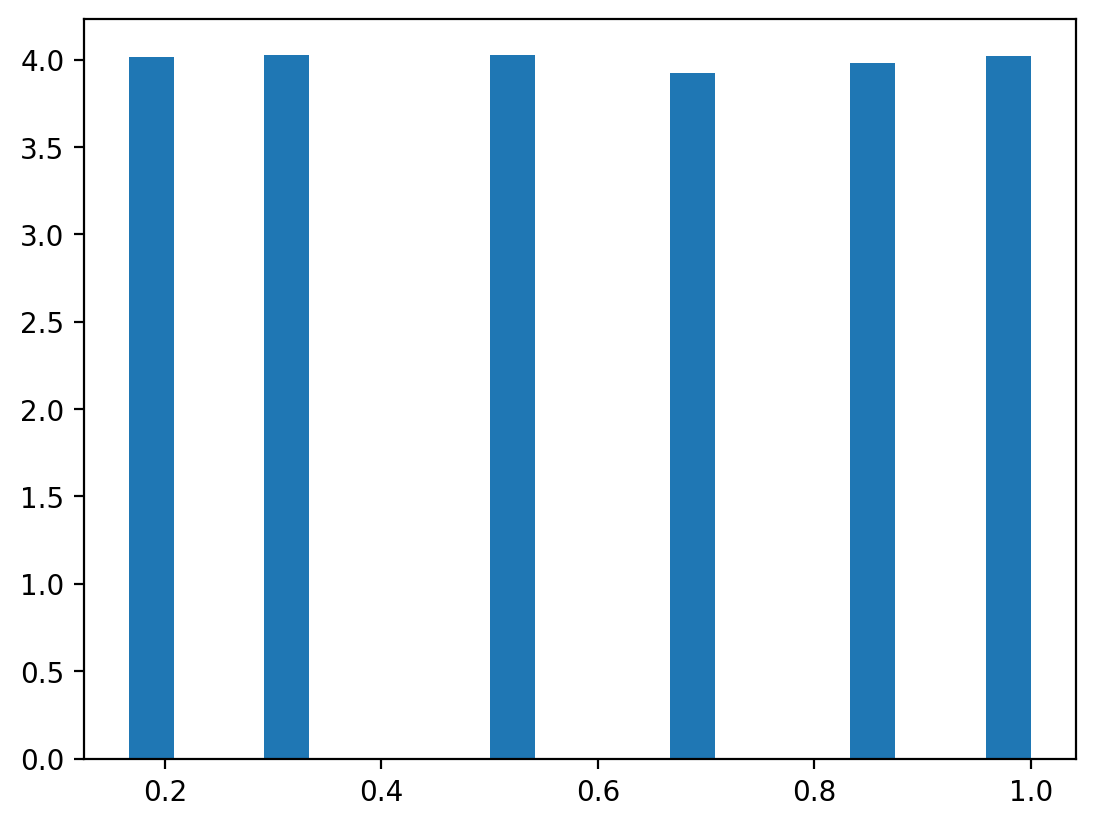

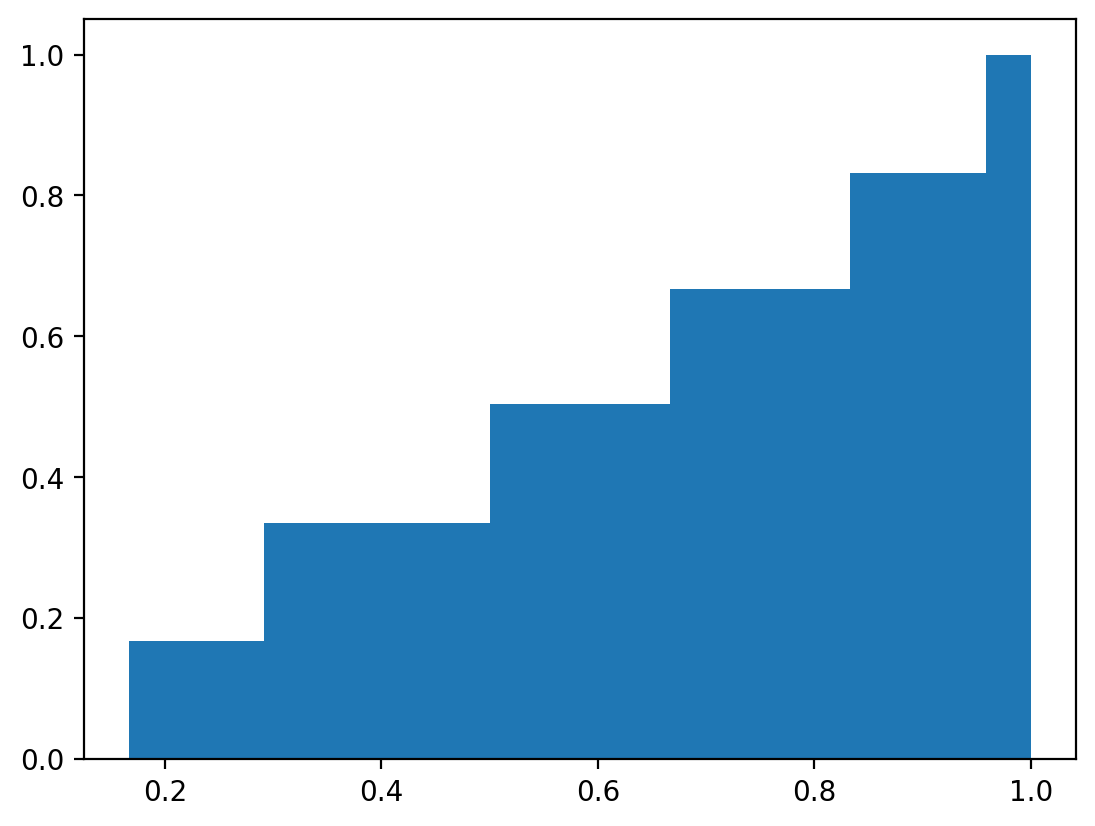



  ********** KL **********


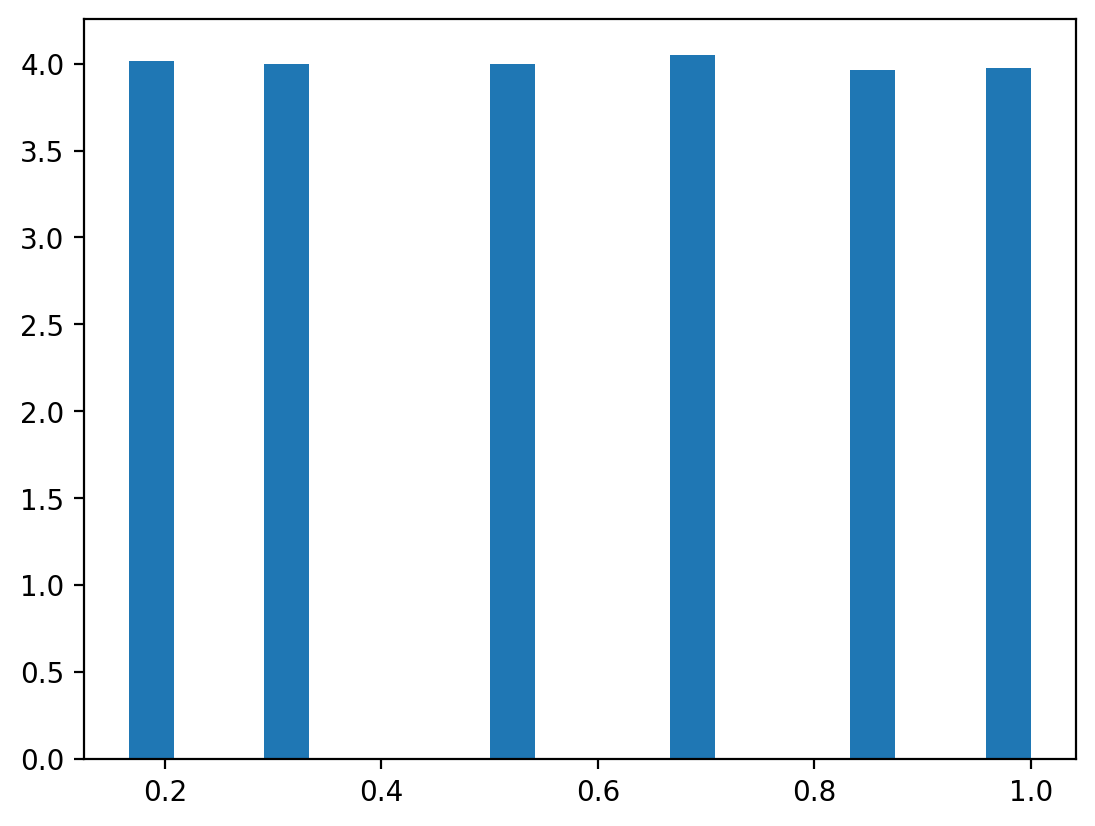

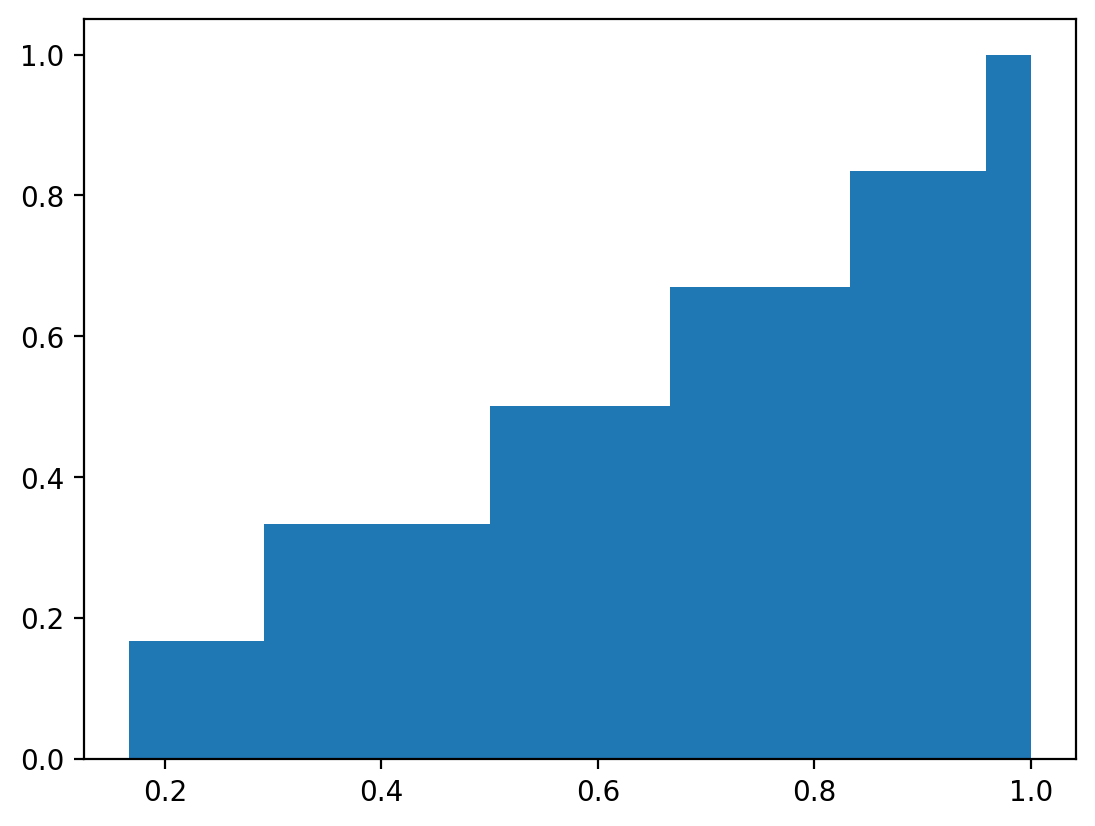

In [8]:
pvals=np.array(pvals)

names=['Class.', 'Proba.', 'TV', 'KL']
for i in range(len(names)):
    print("\n\n  **********",names[i],"**********")
    plt.hist(pvals[:,i+1], cumulative=False, density=True, bins=20)
    plt.show()
    plt.hist(pvals[:,i+1], cumulative=True, density=True, bins=20)
    plt.show()

# Cov. & Conc. 2 shifts

In [9]:
task='reg'

## Cov. shift

In [10]:
pvals=[]

for k in tqdm(range(n_p)):
    for theta in [0]:
        for lamb in values2:

            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)
            Xs, ys, Xt, yt = Xs.squeeze(), ys.squeeze(), Xt.squeeze(), yt.squeeze()
            
            ### KS ###
            pval_ks=list(stats.ks_2samp(Xs,Xt))[1]
            
            ### MMD ###
            pval_mmd = MMD(Xs,Xt) 
            
            ### Classifier ###
            pval_class = classifier_test(Xs_train, Xs_test, Xt_train, Xt_test)
            
            ### TV ###
            Xbins = np.percentile(np.hstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)    
            pval_tv = permut_test(tv,Xs_bin,Xt_bin,B)
            
            ### Ours ###
            covshift_model = KL(boost=False, cv=None)
            covshift_model.fit(Xs_train, Xt_train)
            cov=Permut(Xs_test, Xt_test, covshift_model, B=B, verbose=False)
            pval_kl = cov['pval']
            
            ### Output ###
            pvals.append([lamb, pval_ks, pval_mmd, pval_class, pval_tv, pval_kl])

100%|███████████████████████████████████| 50000/50000 [8:07:56<00:00,  1.71it/s]




  ********** KS **********


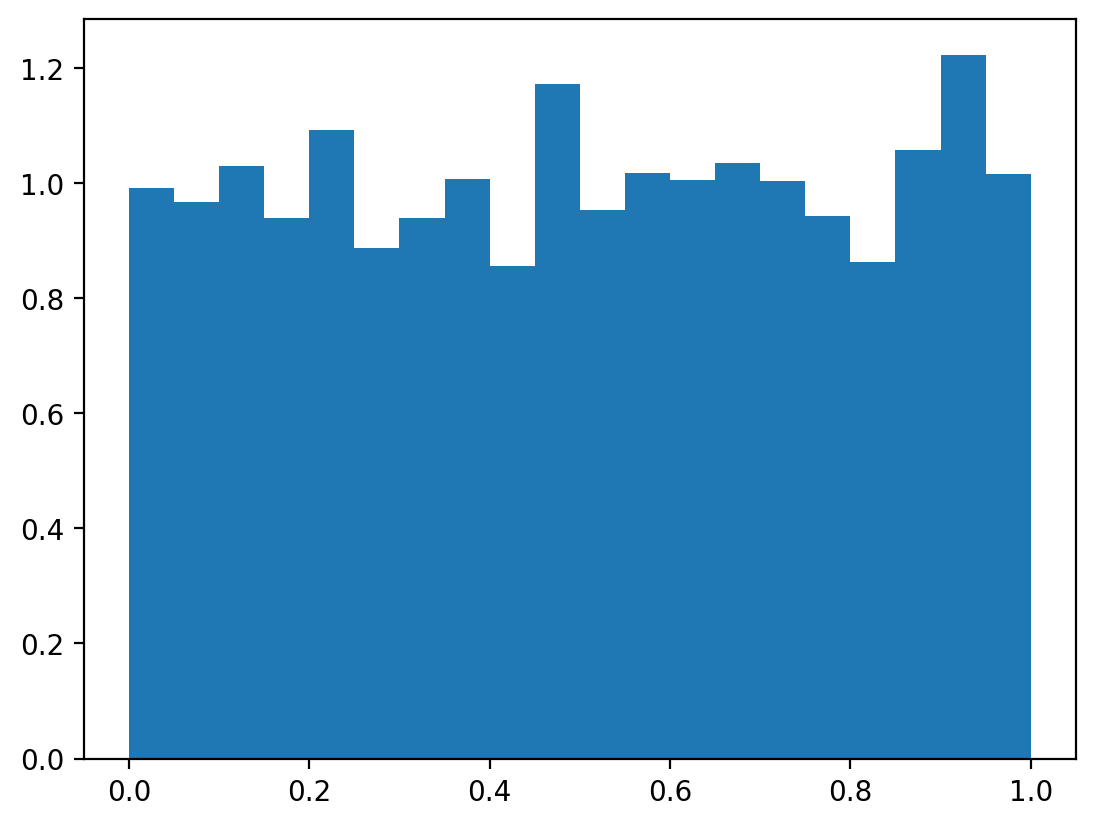

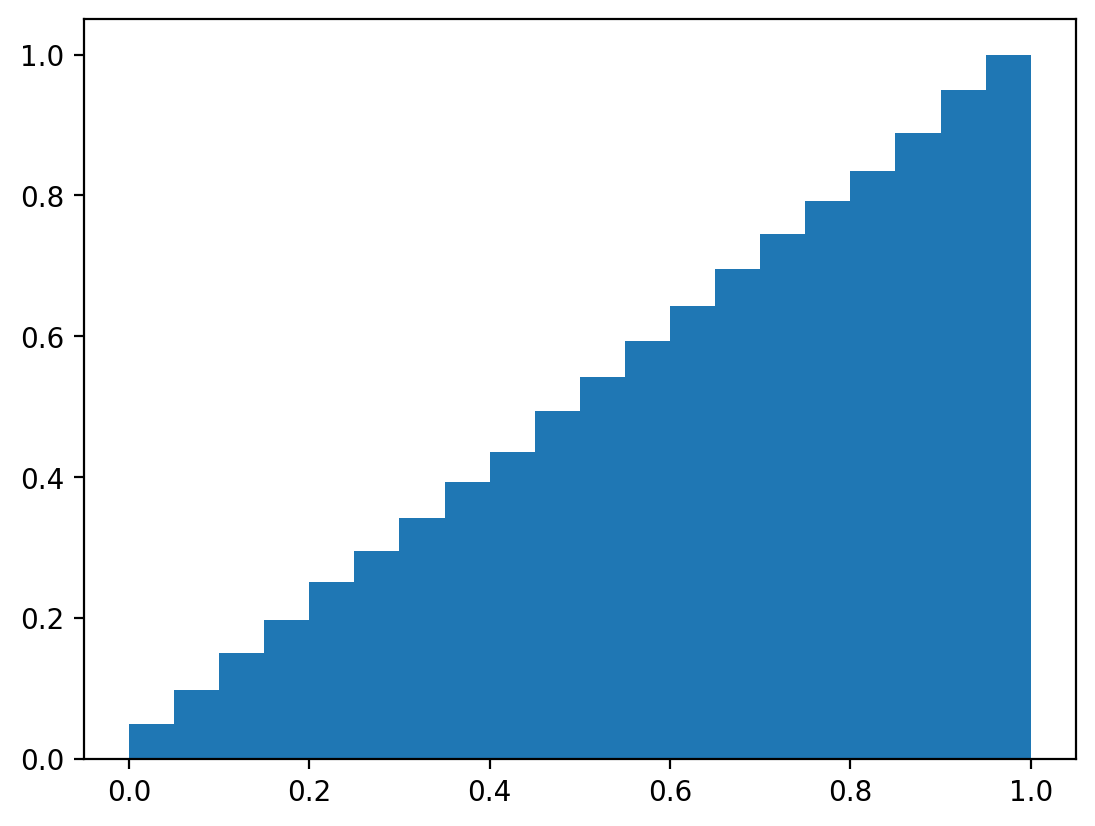



  ********** MMD **********


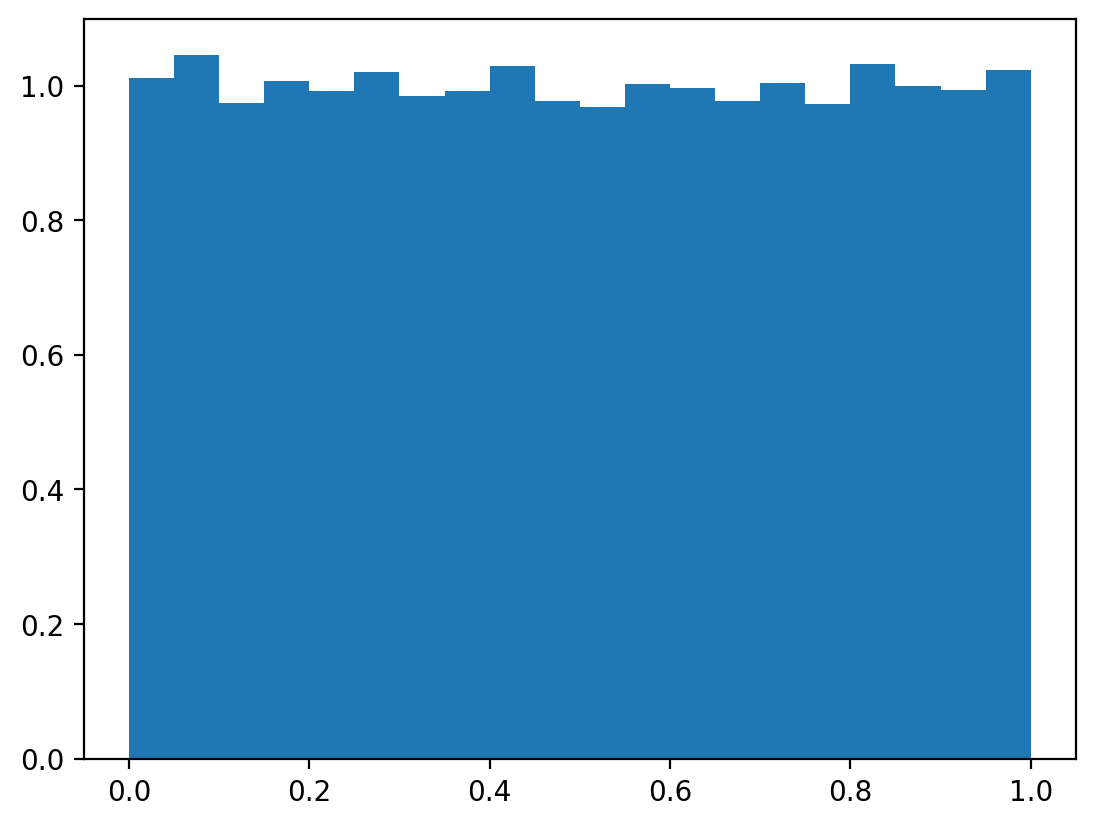

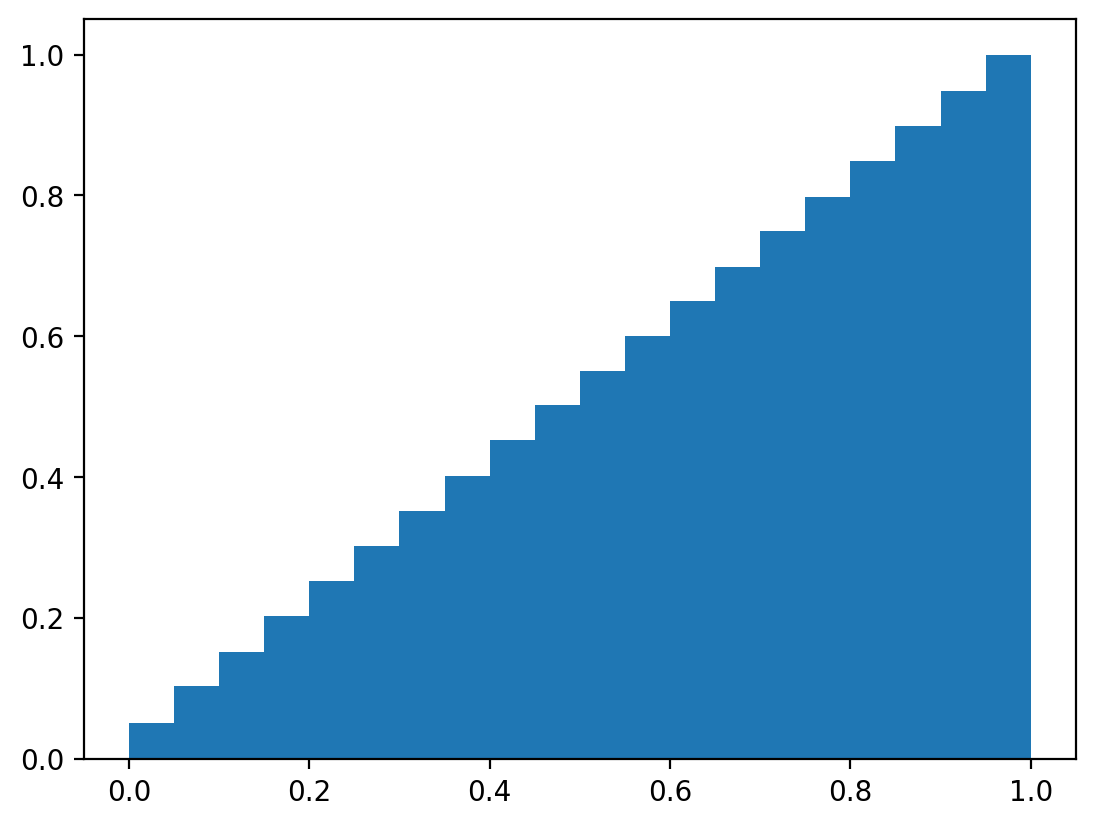



  ********** Class. **********


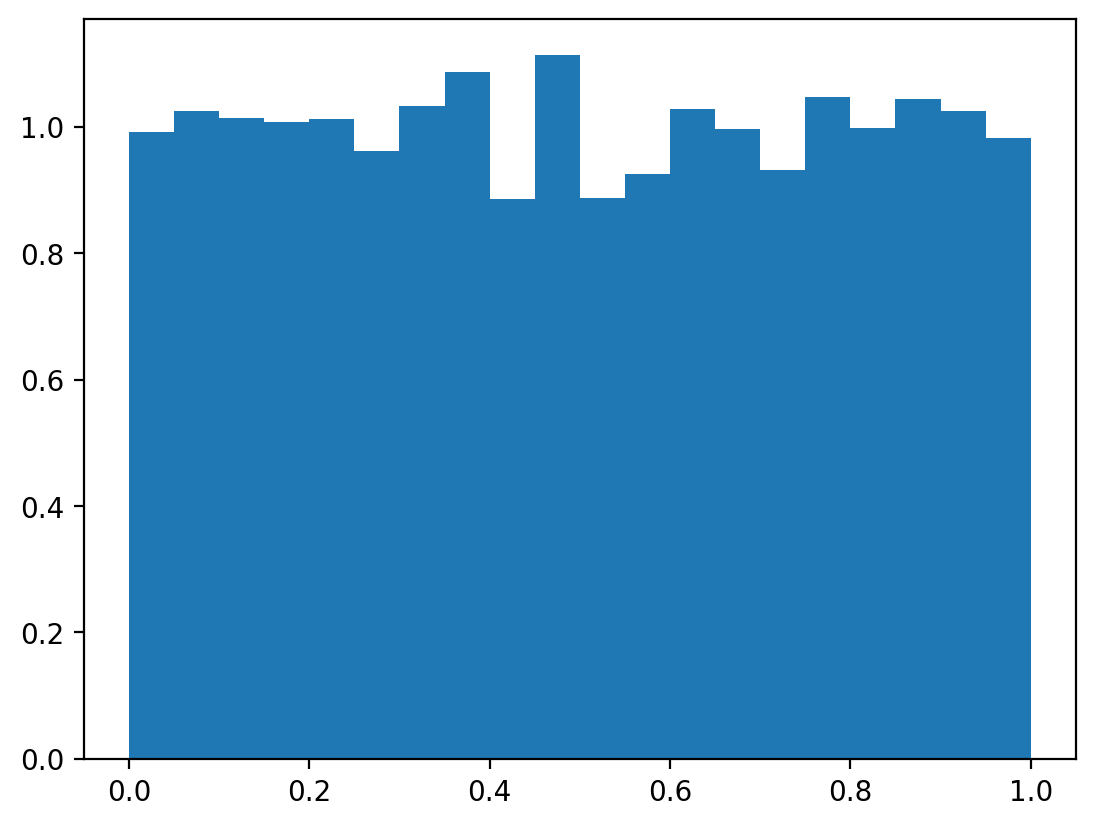

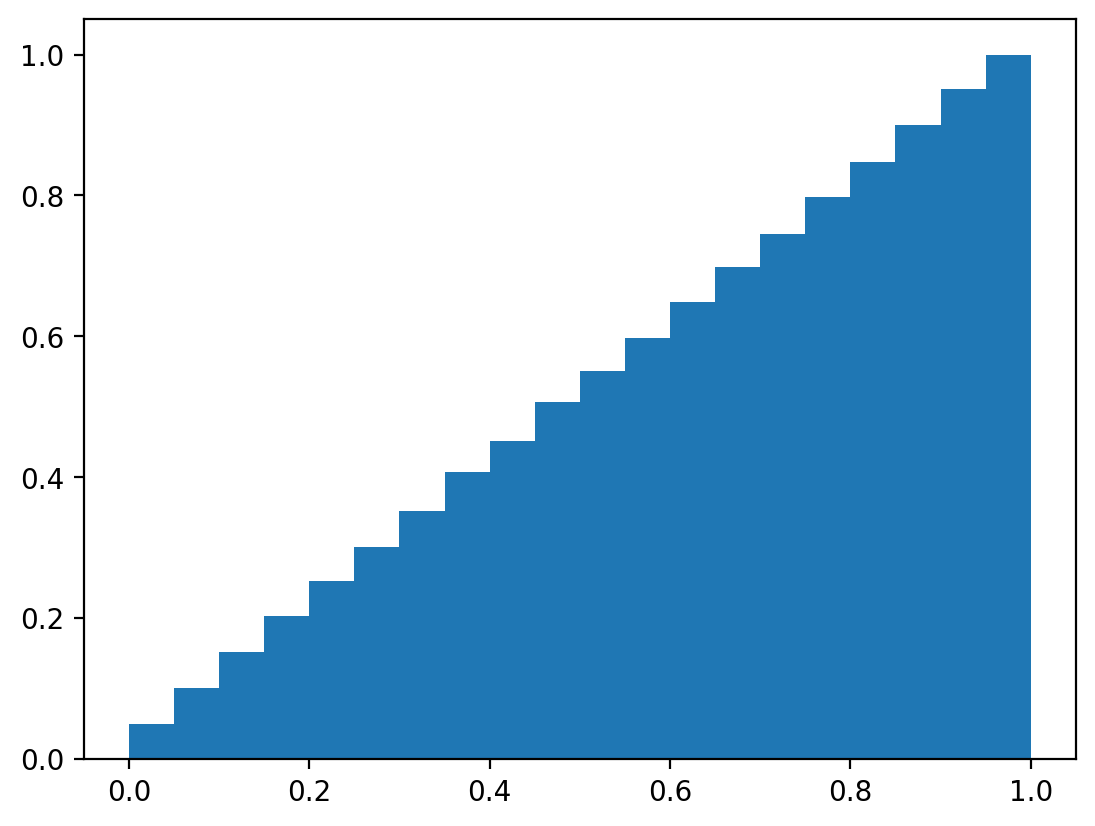



  ********** TV **********


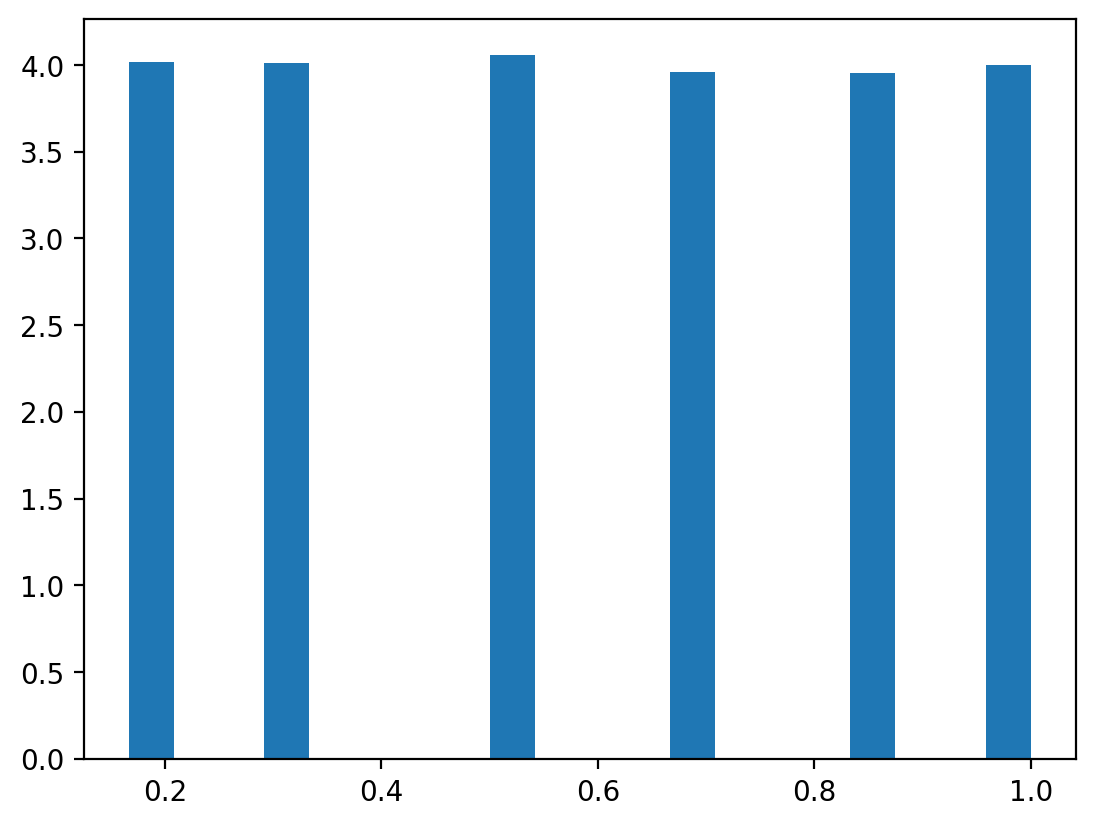

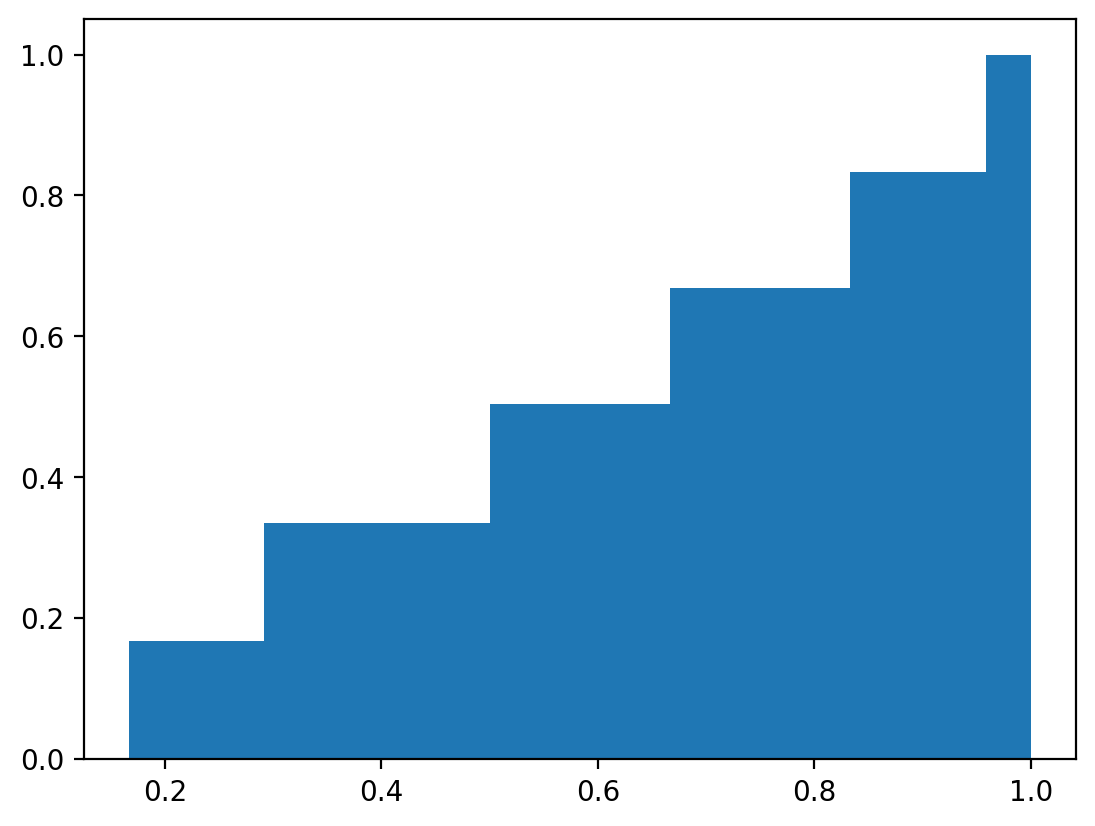



  ********** KL **********


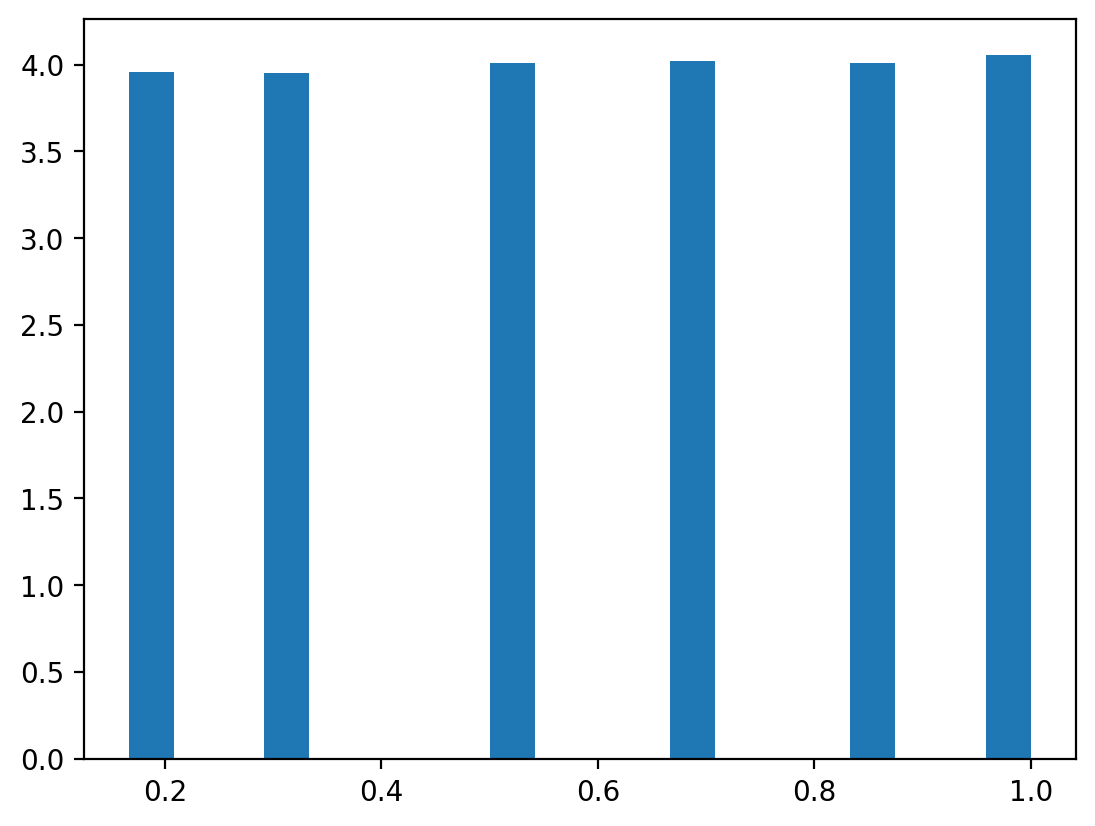

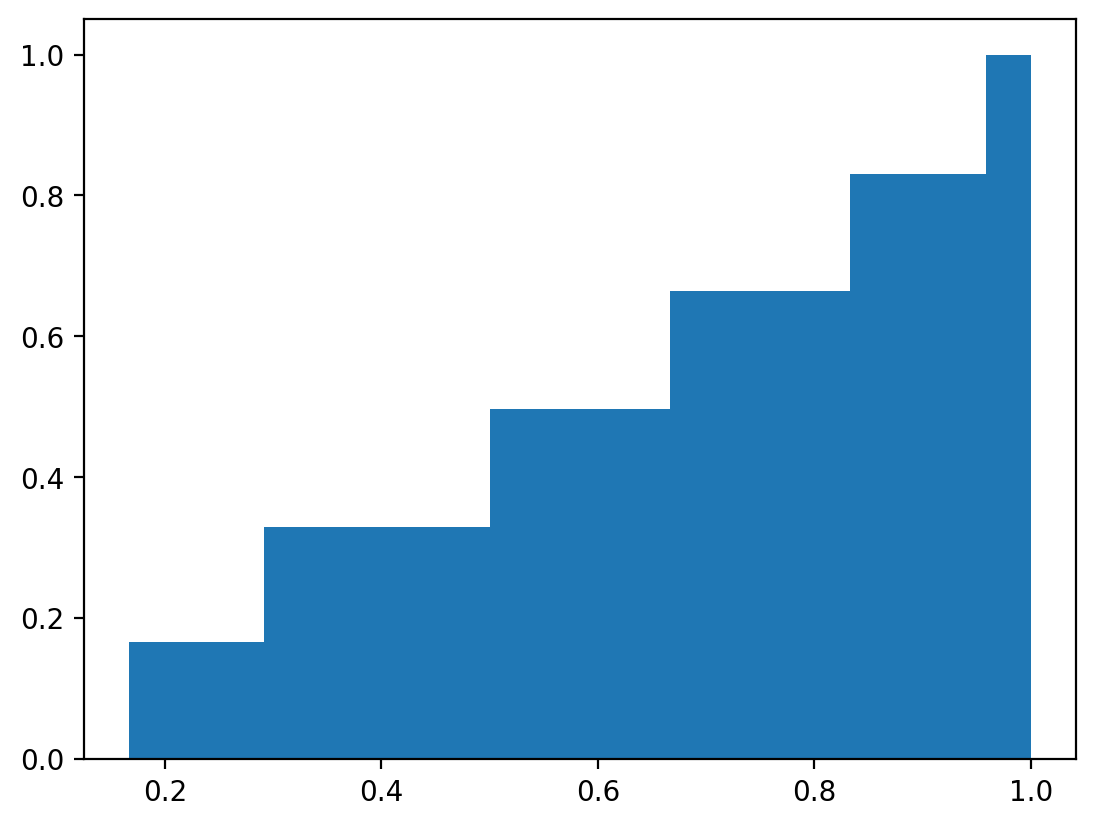

In [11]:
pvals=np.array(pvals)

names=['KS', 'MMD', 'Class.', 'TV', 'KL']
for i in range(len(names)):
    print("\n\n  **********",names[i],"**********")
    plt.hist(pvals[:,i+1], cumulative=False, density=True, bins=20)
    plt.show()
    plt.hist(pvals[:,i+1], cumulative=True, density=True, bins=20)
    plt.show()

## Conc shift 2

In [12]:
pvals=[]

for k in tqdm(range(n_p)):
    for theta in values2:
        for lamb in [0]:

            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)

            # Training CDE
            cd_model = cde_regH0() 
            
            ### class & proba
            pval_class, pval_proba = ci_test2(Xs_train, Xs_test, ys_train, ys_test, Xt_train, Xt_test, yt_train, yt_test, cd_model, B, boost=True, cv=None)
            
            ### TV ###
            #(we use only the test set because we used the training set to train the cde)
            Xs, ys, Xt, yt = Xs_test.squeeze(), ys_test.squeeze(), Xt_test.squeeze(), yt_test.squeeze()
            
            Xbins = np.percentile(np.hstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)
            ybins = np.percentile(np.hstack((ys,yt)), q=perc)
            ys_bin, yt_bin = np.digitize(ys, ybins), np.digitize(yt, ybins)
            
            concshift=tv_conc(Xs_bin,ys_bin,Xt_bin,yt_bin)
            concperm = []

            for b in range(B):
                ys_hat, yt_hat = cd_model.sample(Xs_test), cd_model.sample(Xt_test)
                ybins = np.percentile(np.hstack((ys_hat,yt_hat)), q=perc)
                ys_bin_hat, yt_bin_hat = np.digitize(ys_hat, ybins), np.digitize(yt_hat, ybins)
                concperm.append(tv_conc(Xs_bin,ys_bin_hat,Xt_bin,yt_bin_hat))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            concperm=np.array(concperm)
            concperm=concperm+np.random.normal(0,s,concperm.shape[0])
            concshift=concshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(concperm) >= concshift))/(B+1)
            
            ### Ours ###
            totshift_model = KL(boost=False, cv=None)
            totshift_model.fit(Zs_train, Zt_train)
            covshift_model = KL(boost=False, cv=None)
            covshift_model.fit(Xs_train, Xt_train)

            ###
            conc2=CondRand(Xs_test, ys_test, Xt_test, yt_test, 
                           cd_model, totshift_model, covshift_model, B=B, verbose=False)
            
            pval_kl = conc2['pval']
            
            ### Output ###
            pvals.append([theta, pval_class, pval_proba, pval_tv, pval_kl])

100%|███████████████████████████████████| 50000/50000 [2:53:12<00:00,  4.81it/s]




  ********** Class. **********


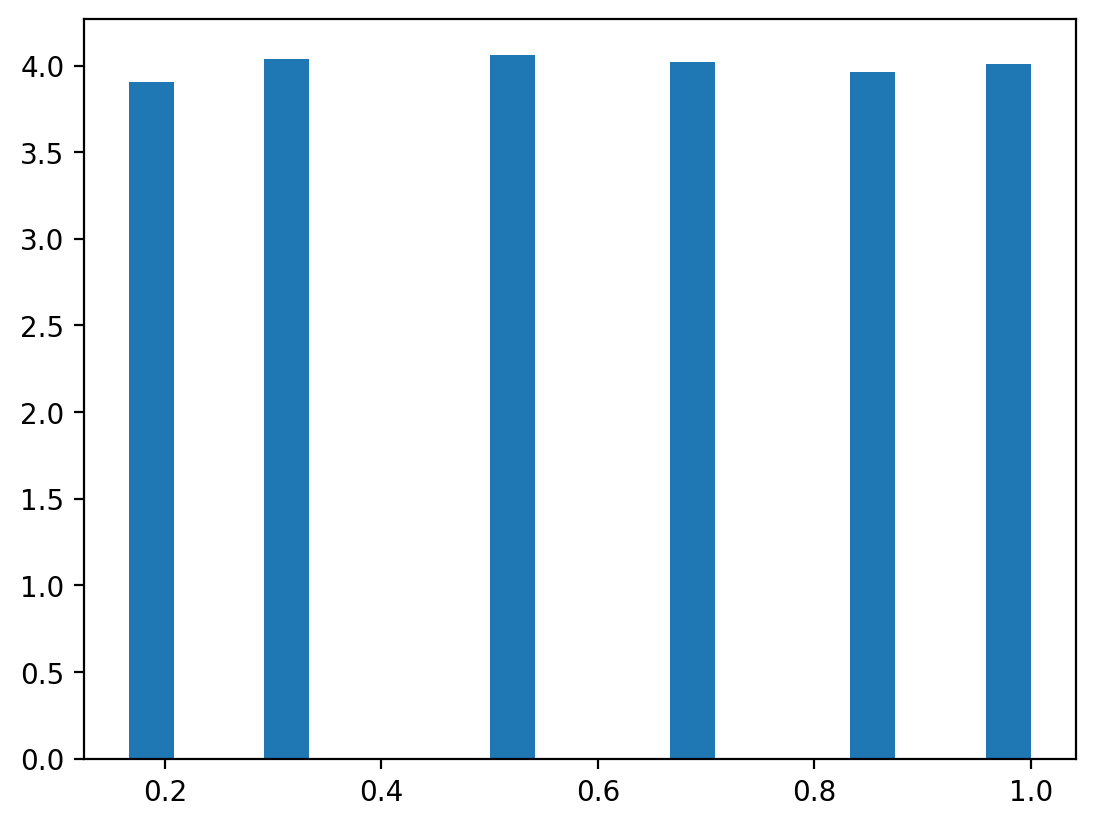

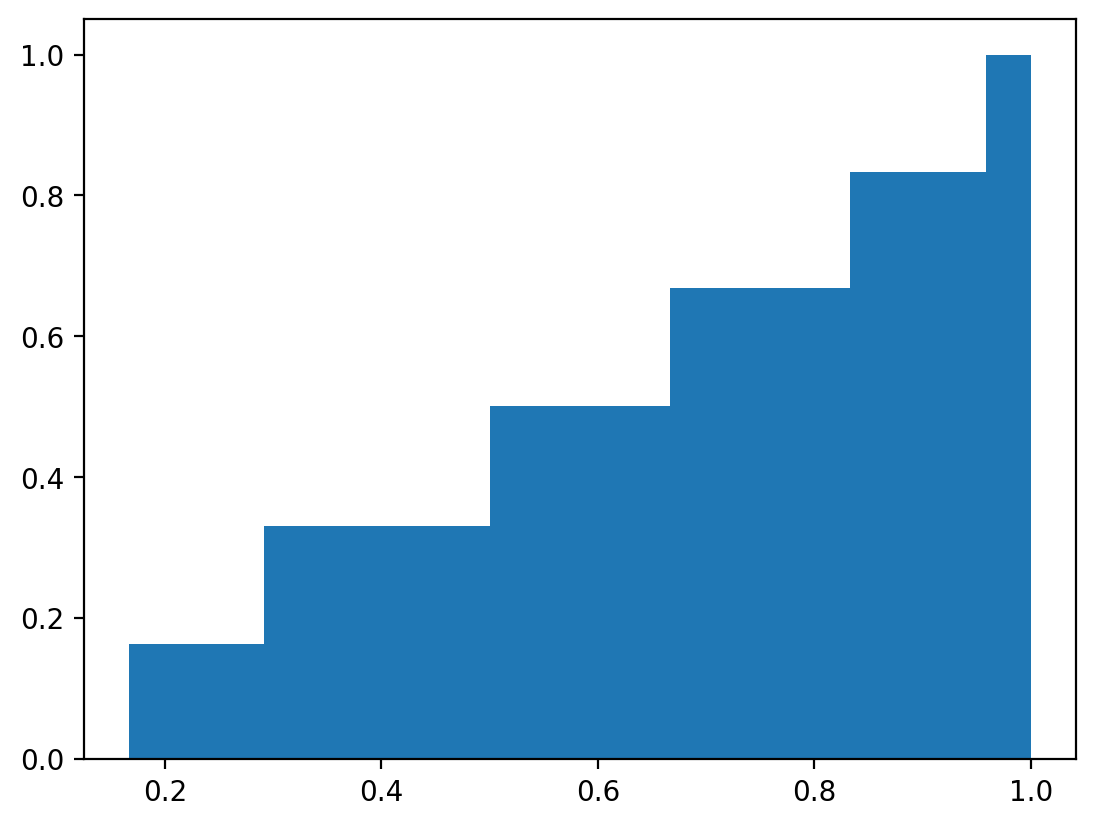



  ********** Proba. **********


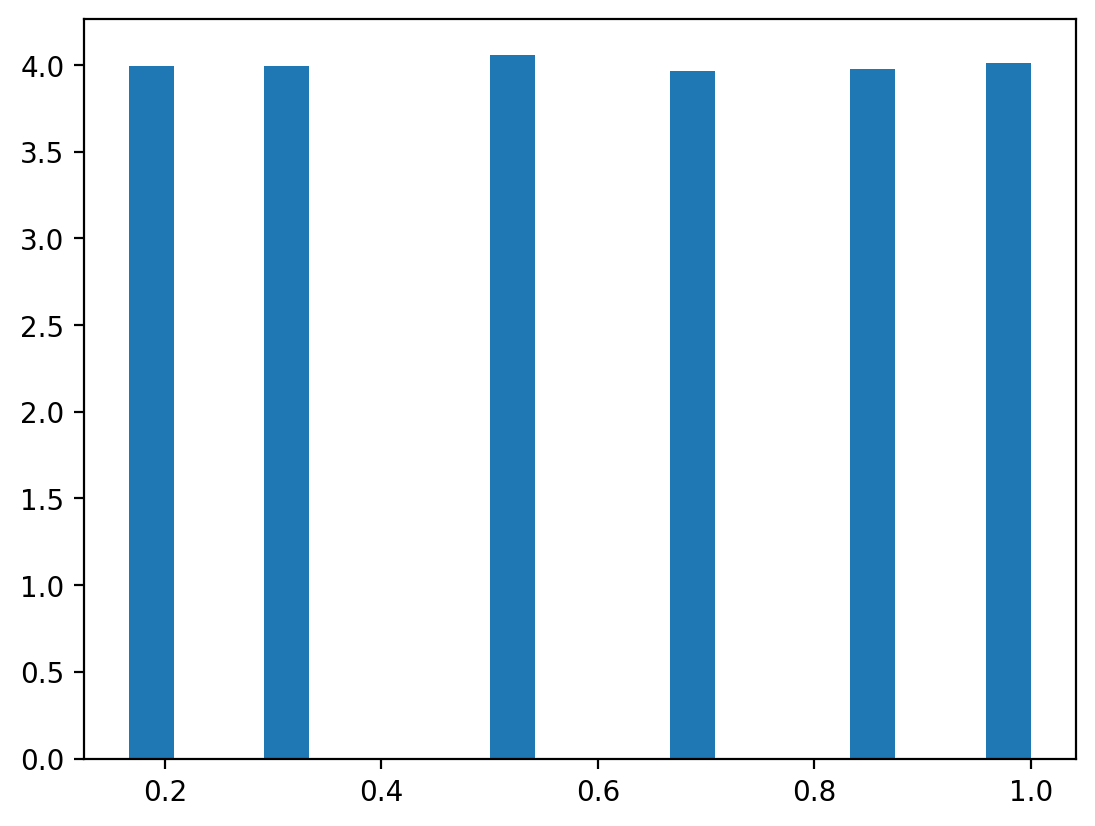

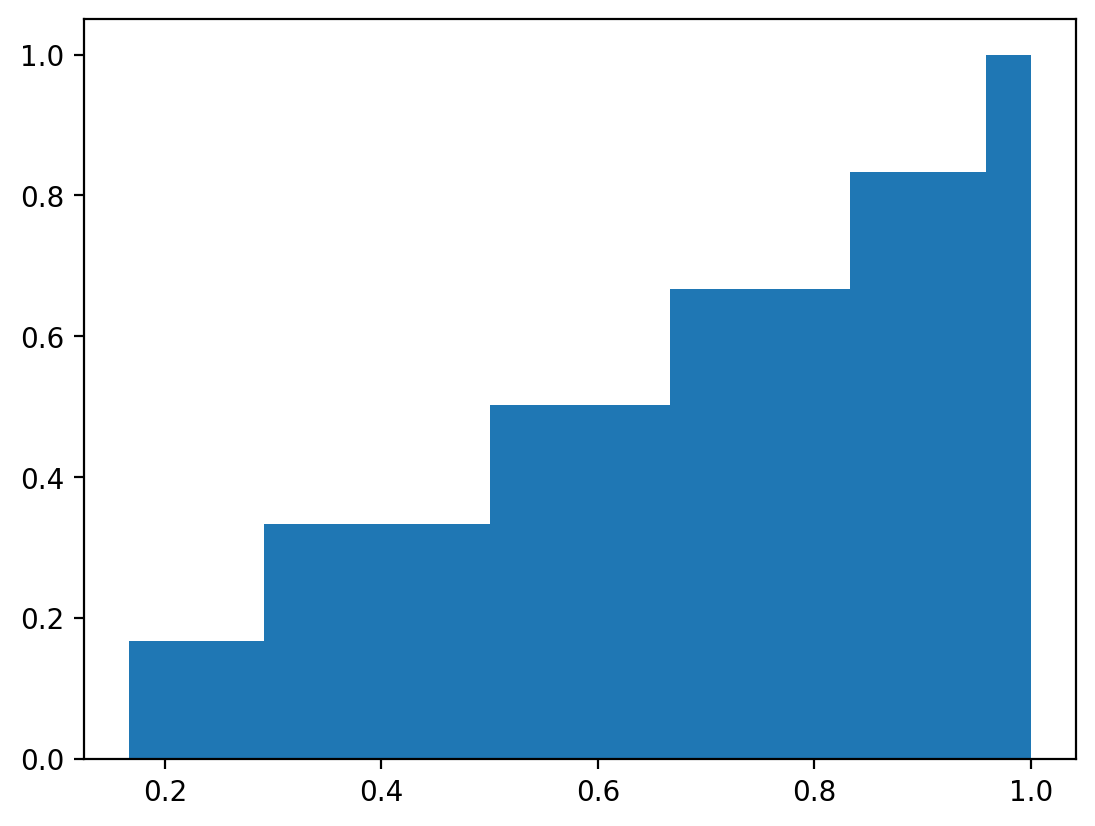



  ********** TV **********


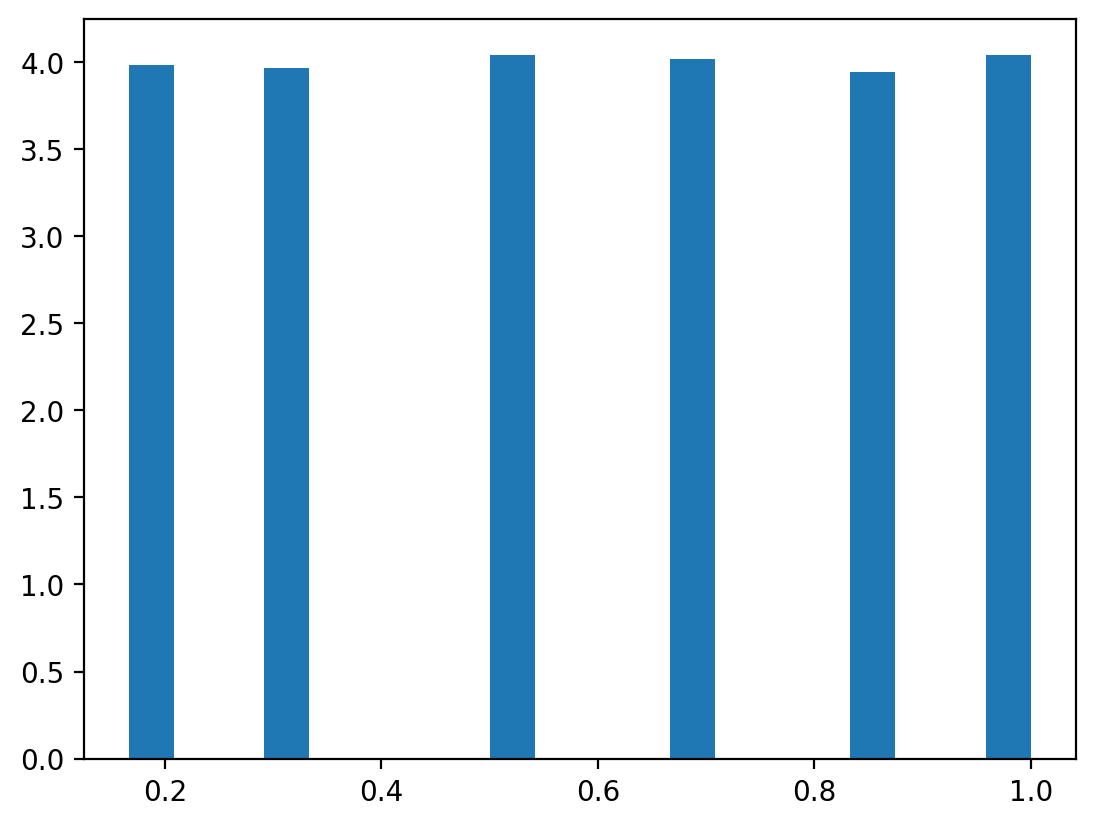

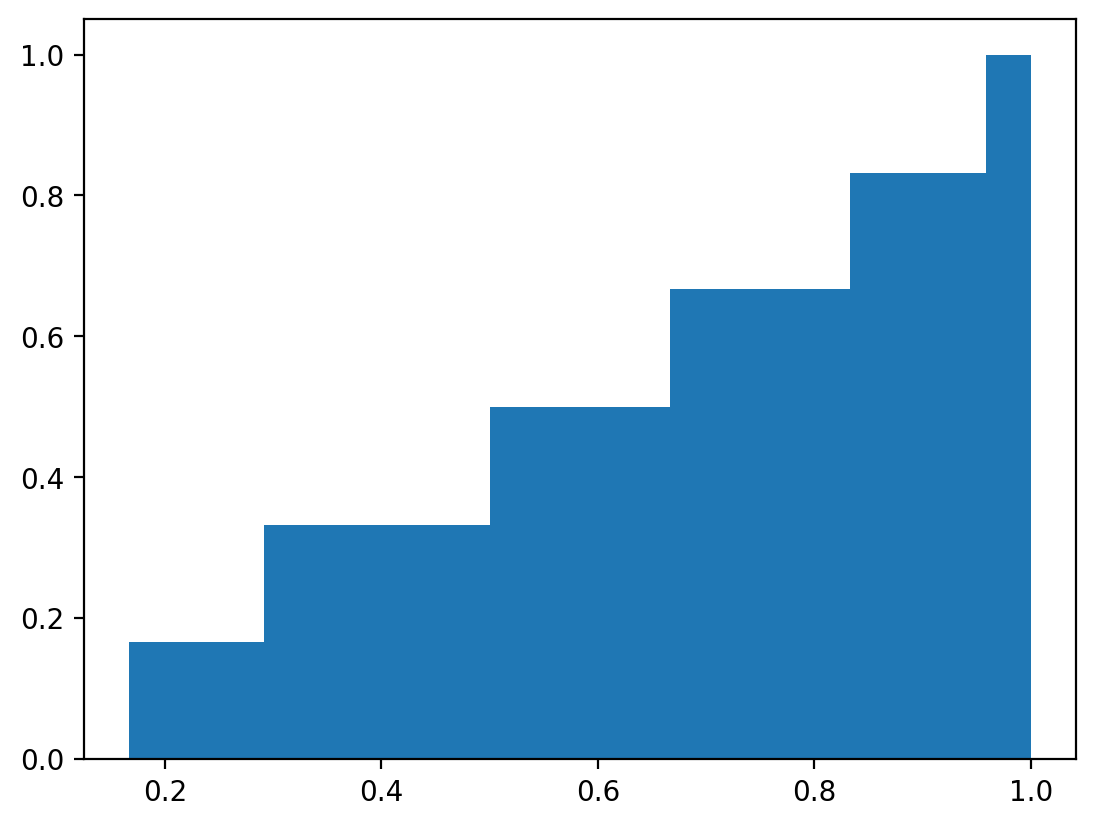



  ********** KL **********


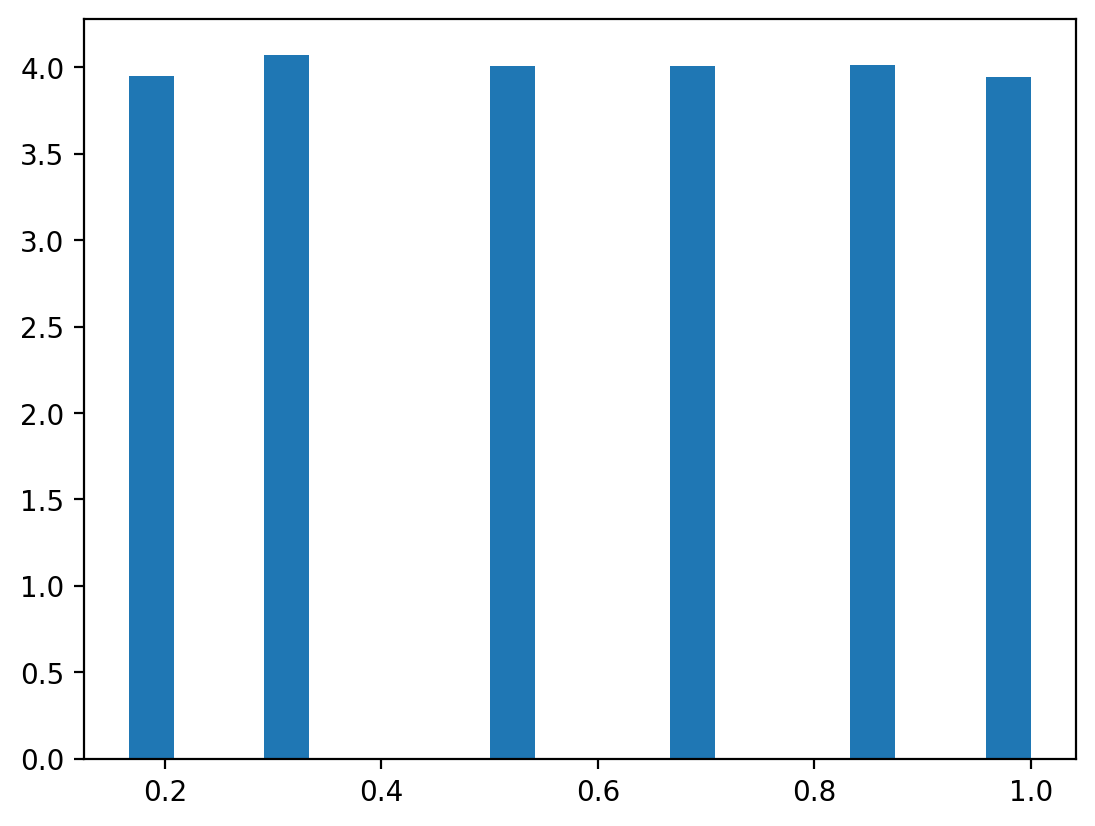

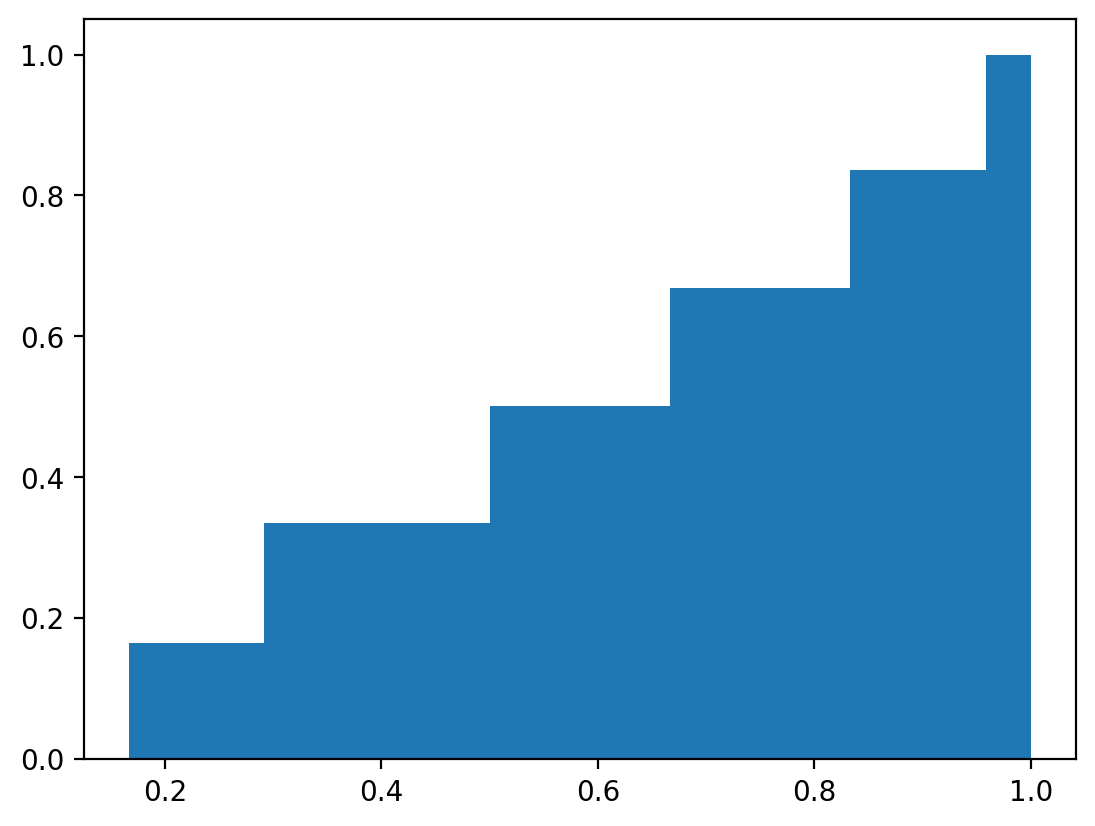

In [13]:
pvals=np.array(pvals)
names=['Class.', 'Proba.', 'TV', 'KL']

for i in range(len(names)):
    print("\n\n  **********",names[i],"**********")
    plt.hist(pvals[:,i+1], cumulative=False, density=True, bins=20)
    plt.show()
    plt.hist(pvals[:,i+1], cumulative=True, density=True, bins=20)
    plt.show()